In [2]:
import pandas as pd
import numpy as np
import hashlib
import psycopg2
from sqlalchemy import create_engine
import warnings

In [ ]:
def crear_dataframe_enriquecido_desde_db(db_params, period_order, period_order_name):
    """
    Se conecta a la base de datos, extrae y une datos de calificaciones y grupos,
    y enriquece el DataFrame resultante con información contextual de los períodos.

    Args:
        db_params (dict): Diccionario con las credenciales de la base de datos.
        period_order (list): Lista de IDs de los períodos.
        period_order_name (list): Lista de nombres de los períodos.

    Returns:
        pd.DataFrame: Un único DataFrame enriquecido y listo para el análisis, o None si falla.
    """
    print("Iniciando el proceso de creación del DataFrame...")

    try:
        # --- PASO 1: Conexión a la Base de Datos usando SQLAlchemy ---
        print("Estableciendo conexión con la base de datos PostgreSQL...")
        engine_url = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}/{db_params['dbname']}"
        engine = create_engine(engine_url)
        
        # --- PASO 2: Definir y ejecutar la consulta SQL ---
        sql_query = """
        SELECT
            c.matricula,
            g.id_carrera,
            c.id_grupo,
            c.id_materia,
            g.semestre,
            g.id_periodo AS periodo,
            -- Calificaciones
            c.p1, c.p2, c.p3, c.o, c.pf, c.e1, c.e2, c.esp,
            -- Asistencias
            c.a1, c.a2, c.a3, c.oa, c.pa
        FROM
            nes_calificaciones AS c
        JOIN
            nes_grupos AS g ON c.id_grupo = g.id_grupo;
        """
        
        print("Ejecutando consulta SQL para extraer y unir los datos...")
        df = pd.read_sql(sql_query, engine)
        print(f"Consulta completada. Se extrajeron {len(df)} registros.")

    except Exception as e:
        print(f"ERROR: No se pudo conectar a la base de datos o ejecutar la consulta: {e}")
        return None

    # --- PASO 3: Ingeniería de Características (Identificador único y Anonimización) ---
    print("\nCreando identificador único 'alumno_carrera_id' y anonimizando...")
    # Se crea el ID combinando matrícula y carrera para tratar cambios de carrera como nuevos perfiles
    df['alumno_carrera_id'] = df['matricula'].astype(str) + '_' + df['id_carrera'].astype(str)
    
    # Se aplica un hash SHA256 para anonimizar este nuevo identificador
    df['alumno_carrera_hash'] = df['alumno_carrera_id'].apply(
        lambda x: hashlib.sha256(x.encode()).hexdigest()
    )
    # Se eliminan las columnas originales para proteger la privacidad
    df = df.drop(columns=['matricula', 'alumno_carrera_id'])
    
    # --- PASO 4: Enriquecimiento con información de períodos ---
    print("Enriqueciendo el DataFrame con información contextual de los períodos...")
    period_name_map = dict(zip(period_order, period_order_name))
    df['nombre_periodo'] = df['periodo'].map(period_name_map)
    
    unmapped_periods = df[df['nombre_periodo'].isnull()]['periodo'].unique()
    if len(unmapped_periods) > 0:
        print(f"ADVERTENCIA: Los siguientes IDs de período no se encontraron en el mapeo: {unmapped_periods}")

    df['año_academico'] = df['nombre_periodo'].str[:9]
    df['tipo_periodo'] = df['nombre_periodo'].str[-1]
    
    conditions = [
        df['tipo_periodo'] == 'A',
        df['tipo_periodo'] == 'B',
        df['tipo_periodo'] == 'V'
    ]
    choices = ['Impar', 'Par', 'Recursamiento']
    df['tipo_semestre'] = np.select(conditions, choices, default='Desconocido')
    
    df['es_periodo_regular'] = df['tipo_periodo'].isin(['A', 'B'])
    
    print("¡Proceso completado exitosamente!")
    
    return df

In [4]:
db_credentials = {
        "host": "localhost",
        "dbname": "NES",
        "user": "postgres",
        "password": "x"
    }

In [5]:
period_order = [35, 36, 40, 39, 42, 43, 41, 46, 47, 44, 49, 50, 48, 53, 54, 51, 52, 56, 55, 58, 59, 57, 61]
period_order_name = [
    "2017-2018A", "2017-2018B", "2017-2018V", "2018-2019A", "2018-2019B", "2018-2019V", 
    "2019-2020A", "2019-2020B", "2019-2020V", "2020-2021A", "2020-2021B", "2020-2021V", 
    "2021-2022A", "2021-2022B", "2021-2022V", "2022-2023A", "2022-2023B", "2022-2023V", 
    "2023-2024A", "2023-2024B", "2023-2024V", "2024-2025A", "2024-2025B"
]

In [6]:
df_final = crear_dataframe_enriquecido_desde_db(db_credentials, period_order, period_order_name)

Iniciando el proceso de creación del DataFrame...
Estableciendo conexión con la base de datos PostgreSQL...
Ejecutando consulta SQL para extraer y unir los datos...
Consulta completada. Se extrajeron 133882 registros.

Creando identificador único 'alumno_carrera_id' y anonimizando...
Enriqueciendo el DataFrame con información contextual de los períodos...
¡Proceso completado exitosamente!


In [7]:
if df_final is not None:
        print("\n--- Vista Previa del DataFrame Final (primeras 5 filas) ---")
        print(df_final.head())
        
        print("\n--- Columnas del DataFrame Final ---")
        print(df_final.columns.tolist())
        
        print(f"\nDimensiones del DataFrame: {df_final.shape[0]} filas, {df_final.shape[1]} columnas.")


--- Vista Previa del DataFrame Final (primeras 5 filas) ---
   id_carrera  id_grupo  id_materia  semestre  periodo    p1    p2    p3  \
0           2      2975       13710         2       61 -10.0 -10.0 -10.0   
1           2      2975       13710         2       61 -10.0 -10.0 -10.0   
2           2      2975       13710         2       61 -10.0 -10.0 -10.0   
3           2      2975       13710         2       61 -10.0 -10.0 -10.0   
4           2      2975       13710         2       61 -10.0 -10.0 -10.0   

      o   pf  ...    a2    a3    oa    pa  \
0 -10.0  0.0  ... -10.0 -10.0 -10.0  25.0   
1 -10.0  0.0  ... -10.0 -10.0 -10.0  25.0   
2 -10.0  0.0  ... -10.0 -10.0 -10.0  22.0   
3 -10.0  0.0  ... -10.0 -10.0 -10.0  23.0   
4 -10.0  0.0  ... -10.0 -10.0 -10.0  25.0   

                                 alumno_carrera_hash  nombre_periodo  \
0  a0bb973b0416d3f4ceb601a627c9c9d99d46f306ccd699...      2024-2025B   
1  578d25e52a24ac996077afc11adb90698d500737270aac...      2024-2025

In [8]:
columnas_numericas = [
    'p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp', 'a1', 'a2', 'a3', 'oa', 'pa'
]

In [9]:
estadisticas = df_final[columnas_numericas].agg(['mean', 'median', 'min', 'max', 'std']).transpose()
estadisticas = estadisticas.rename(columns={
    'mean': 'Media',
    'median': 'Mediana',
    'min': 'Mínimo',
    'max': 'Máximo',
    'std': 'Desviación estándar'
})

print(estadisticas)

         Media  Mediana  Mínimo  Máximo  Desviación estándar
p1    6.455435      7.4   -10.0    10.0             3.621790
p2    5.674854      7.3   -10.0    10.0             5.093707
p3    5.553593      7.4   -10.0    10.0             5.324765
o     5.649781      7.8   -10.0    10.0             5.492562
pf    6.360659      7.4   -10.0    10.0             3.398940
e1   -8.176267    -10.0   -10.0    10.0             4.833230
e2   -9.053577    -10.0   -10.0    10.0             3.511815
esp  -9.887169    -10.0   -10.0    10.0             1.262861
a1   95.093627    100.0   -10.0   100.0            16.237960
a2   88.916889    100.0   -10.0   100.0            28.218431
a3   87.364030    100.0   -10.0   100.0            29.923044
oa   81.174848    100.0   -10.0   100.0            39.191282
pa   89.868541     98.0   -10.0   100.0            22.989811


In [10]:
def limpiar_calificaciones_invalidas(df):
    """
    Reemplaza los valores negativos en las columnas de calificación y asistencia
    con np.nan para representar correctamente los datos faltantes.
    """
    print("Iniciando limpieza de valores negativos...")
    
    # Lista de todas las columnas que pueden contener calificaciones o asistencias
    columnas_a_limpiar = [
        'p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp',
        'a1', 'a2', 'a3', 'oa', 'pa'
    ]
    
    # Asegurarse de que solo se limpian las columnas que existen en el DataFrame
    columnas_existentes = [col for col in columnas_a_limpiar if col in df.columns]
    
    # Usar .mask() para reemplazar donde la condición (valor < 0) es verdadera
    df[columnas_existentes] = df[columnas_existentes].mask(df[columnas_existentes] < 0, np.nan)
    
    print(f"Limpieza completada. Se procesaron {len(columnas_existentes)} columnas.")
    return df

In [ ]:
def crear_dataframe_enriquecido_desde_db_limpio(db_params, period_order, period_order_name):
    """
    Se conecta a la BD, extrae, limpia, transforma y enriquece los datos de los alumnos.

    Args:
        db_params (dict): Diccionario con las credenciales de la base de datos.
        period_order (list): Lista de IDs de los períodos.
        period_order_name (list): Lista de nombres de los períodos.

    Returns:
        pd.DataFrame: Un único DataFrame listo para el análisis, o None si falla.
    """
    print("Iniciando el proceso de creación del DataFrame...")

    try:
        print("Estableciendo conexión con la base de datos PostgreSQL...")
        engine_url = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}/{db_params['dbname']}"
        engine = create_engine(engine_url)
        
        # --- PASO 1: Definir y ejecutar la consulta SQL ---
        sql_query = """
        SELECT
            c.matricula,
            g.id_carrera,
            c.id_grupo,
            c.id_materia,
            g.semestre,
            g.id_periodo AS periodo,
            -- Calificaciones
            c.p1, c.p2, c.p3, c.o, c.pf, c.e1, c.e2, c.esp,
            -- Asistencias
            c.a1, c.a2, c.a3, c.oa, c.pa
        FROM
            nes_calificaciones AS c
        JOIN
            nes_grupos AS g ON c.id_grupo = g.id_grupo;
        """
        
        print("Ejecutando consulta SQL para extraer y unir los datos...")
        df = pd.read_sql(sql_query, engine)
        print(f"Consulta completada. Se extrajeron {len(df)} registros.")

    except Exception as e:
        print(f"ERROR: No se pudo conectar a la base de datos o ejecutar la consulta: {e}")
        return None

    # --- PASO 2: Limpieza de Calificaciones Negativas ---
    df = limpiar_calificaciones_invalidas(df)

    # --- PASO 3: Ingeniería de Características (ID único y Anonimización) ---
    print("\nCreando identificador único 'alumno_carrera_id' y anonimizando...")
    df['alumno_carrera_id'] = df['matricula'].astype(str) + '_' + df['id_carrera'].astype(str)
    
    df['alumno_carrera_hash'] = df['alumno_carrera_id'].apply(
        lambda x: hashlib.sha256(x.encode()).hexdigest()
    )
    df = df.drop(columns=['matricula', 'alumno_carrera_id'])
    
    # --- PASO 4: Enriquecimiento con información de períodos ---
    print("Enriqueciendo el DataFrame con información contextual de los períodos...")
    period_name_map = dict(zip(period_order, period_order_name))
    df['nombre_periodo'] = df['periodo'].map(period_name_map)
    
    unmapped_periods = df[df['nombre_periodo'].isnull()]['periodo'].unique()
    if len(unmapped_periods) > 0:
        print(f"ADVERTENCIA: Los siguientes IDs de período no se encontraron en el mapeo: {unmapped_periods}")

    df['año_academico'] = df['nombre_periodo'].str[:9]
    df['tipo_periodo'] = df['nombre_periodo'].str[-1]
    
    conditions = [
        df['tipo_periodo'] == 'A',
        df['tipo_periodo'] == 'B',
        df['tipo_periodo'] == 'V'
    ]
    choices = ['Impar', 'Par', 'Recursamiento']
    df['tipo_semestre'] = np.select(conditions, choices, default='Desconocido')
    
    df['es_periodo_regular'] = df['tipo_periodo'].isin(['A', 'B'])
    
    print("¡Proceso completado exitosamente!")
    
    return df

In [12]:
df_final_limpio = crear_dataframe_enriquecido_desde_db_limpio(db_credentials, period_order, period_order_name)

Iniciando el proceso de creación del DataFrame...
Estableciendo conexión con la base de datos PostgreSQL...
Ejecutando consulta SQL para extraer y unir los datos...


Consulta completada. Se extrajeron 133882 registros.
Iniciando limpieza de valores negativos...
Limpieza completada. Se procesaron 13 columnas.

Creando identificador único 'alumno_carrera_id' y anonimizando...
Enriqueciendo el DataFrame con información contextual de los períodos...
¡Proceso completado exitosamente!


In [13]:
if df_final_limpio is not None:
        print("\n--- Vista Previa del DataFrame Final (primeras 5 filas) ---")
        print(df_final_limpio.head())
        
        print("\n--- Estadísticas Descriptivas (Después de la limpieza) ---")
        # Mostramos las estadísticas para verificar que los mínimos ya no son negativos
        print(df_final_limpio[['p1', 'p2', 'p3', 'o','pf', 'a1', 'a2', 'a3', 'oa', 'pa']].describe())


--- Vista Previa del DataFrame Final (primeras 5 filas) ---
   id_carrera  id_grupo  id_materia  semestre  periodo  p1  p2  p3   o   pf  \
0           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
1           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
2           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
3           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
4           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   

   ...  a2  a3  oa    pa                                alumno_carrera_hash  \
0  ... NaN NaN NaN  25.0  a0bb973b0416d3f4ceb601a627c9c9d99d46f306ccd699...   
1  ... NaN NaN NaN  25.0  578d25e52a24ac996077afc11adb90698d500737270aac...   
2  ... NaN NaN NaN  22.0  9b55af95c90111bbbd378f36809598c140d83ab73123c2...   
3  ... NaN NaN NaN  23.0  39fbe56b18793fb13a89906b591f22edb848829b162afa...   
4  ... NaN NaN NaN  25.0  f9e67e37da9e73eed6447e3fb490a95ea80b1ef4013

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.set_theme(style="whitegrid")

def visualizar_histogramas(df):
    """
    Crea y muestra histogramas para las columnas numéricas clave.
    Un histograma nos ayuda a ver la forma y distribución de los datos.
    """
    print("--- Generando Histogramas ---")
    
    # Seleccionamos las columnas más representativas para visualizar
    columnas_a_visualizar = [
        'p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp',
        'a1', 'a2', 'a3', 'oa', 'pa'
    ]
    
    # Creamos una figura con 4x4 subplots para organizar los gráficos
    fig, axes = plt.subplots(4, 4, figsize=(14, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(columnas_a_visualizar):
        sns.histplot(data=df, x=col, kde=True, ax=axes[i], bins=30)
        axes[i].set_title(f'Distribución de {col}', fontsize=14)
        axes[i].set_xlabel('Valor', fontsize=12)
        axes[i].set_ylabel('Frecuencia', fontsize=12)
        
    plt.suptitle('Histogramas de Calificaciones y Asistencias', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
def visualizar_matriz_correlacion(df):
    """
    Calcula y visualiza una matriz de correlación para las variables numéricas.
    Nos ayuda a entender qué tan fuerte es la relación lineal entre dos variables.
    """
    print("\n--- Calculando y Generando Matriz de Correlación ---")
    
    columnas_numericas = [
        'p1', 'p2', 'p3', 'o', 'pf', 'e1', 'e2', 'esp',
        'a1', 'a2', 'a3', 'oa', 'pa'
    ]
    df_numerico = df[columnas_numericas]
    
    # Calculamos la matriz de correlación
    # El método de Pearson es el estándar para relaciones lineales
    matriz_corr = df_numerico.corr(method='pearson')
    
    # Creamos la visualización (heatmap)
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        matriz_corr,
        annot=False,
        cmap='coolwarm', # Un mapa de color que va de azul (negativo) a rojo (positivo)
        linewidths=0.5
    )
    plt.title('Matriz de Correlación de Calificaciones y Asistencias', fontsize=20)
    plt.show()

--- Generando Histogramas ---


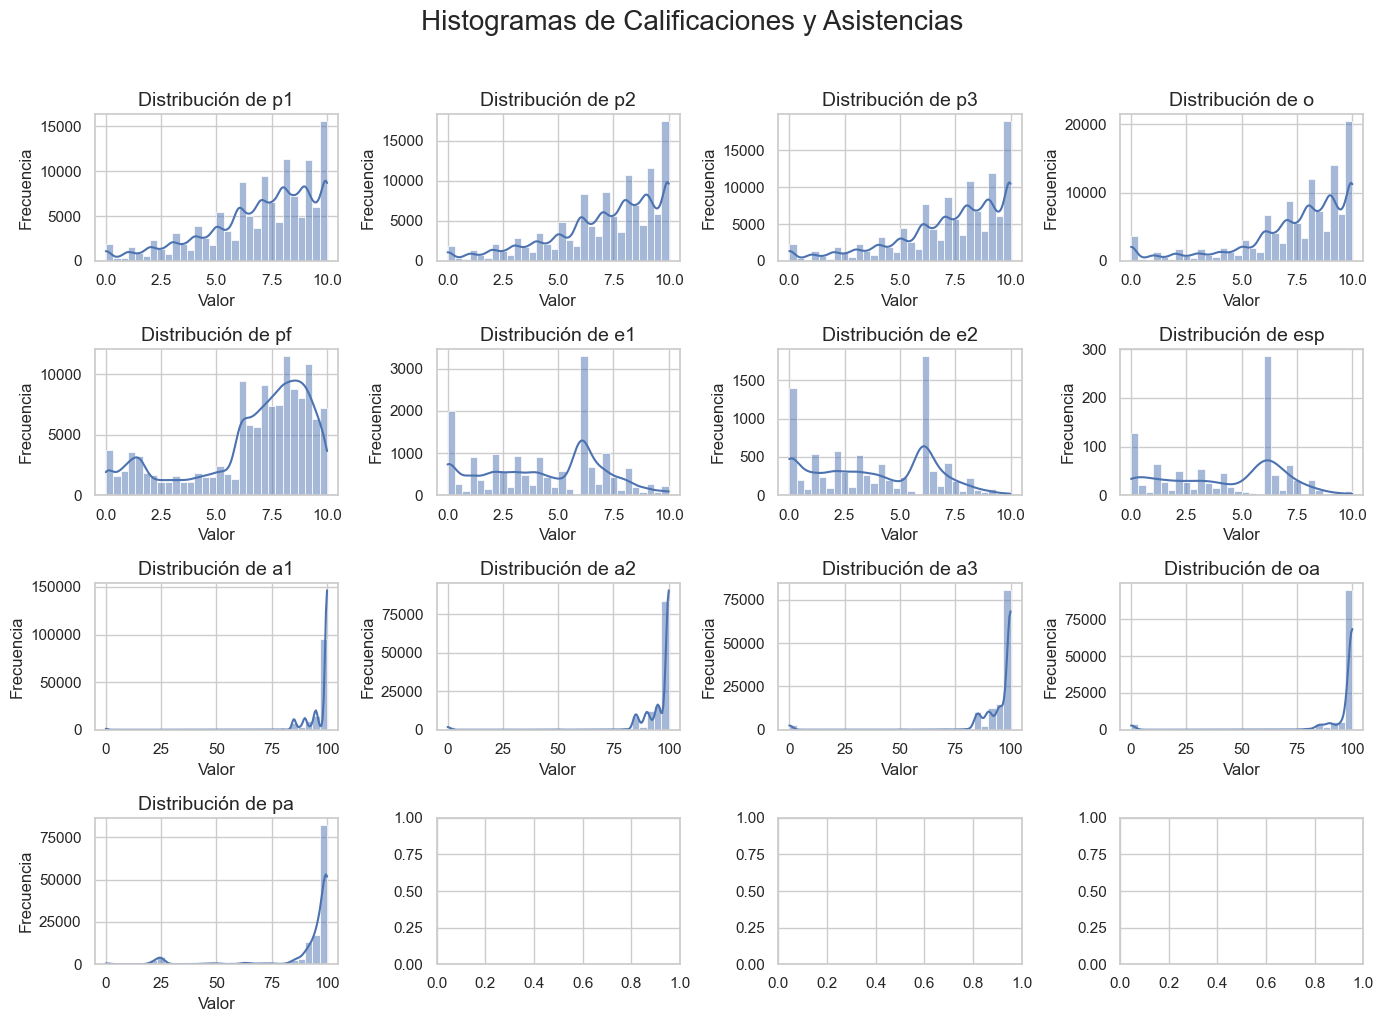

In [27]:
visualizar_histogramas(df_final_limpio)


--- Calculando y Generando Matriz de Correlación ---


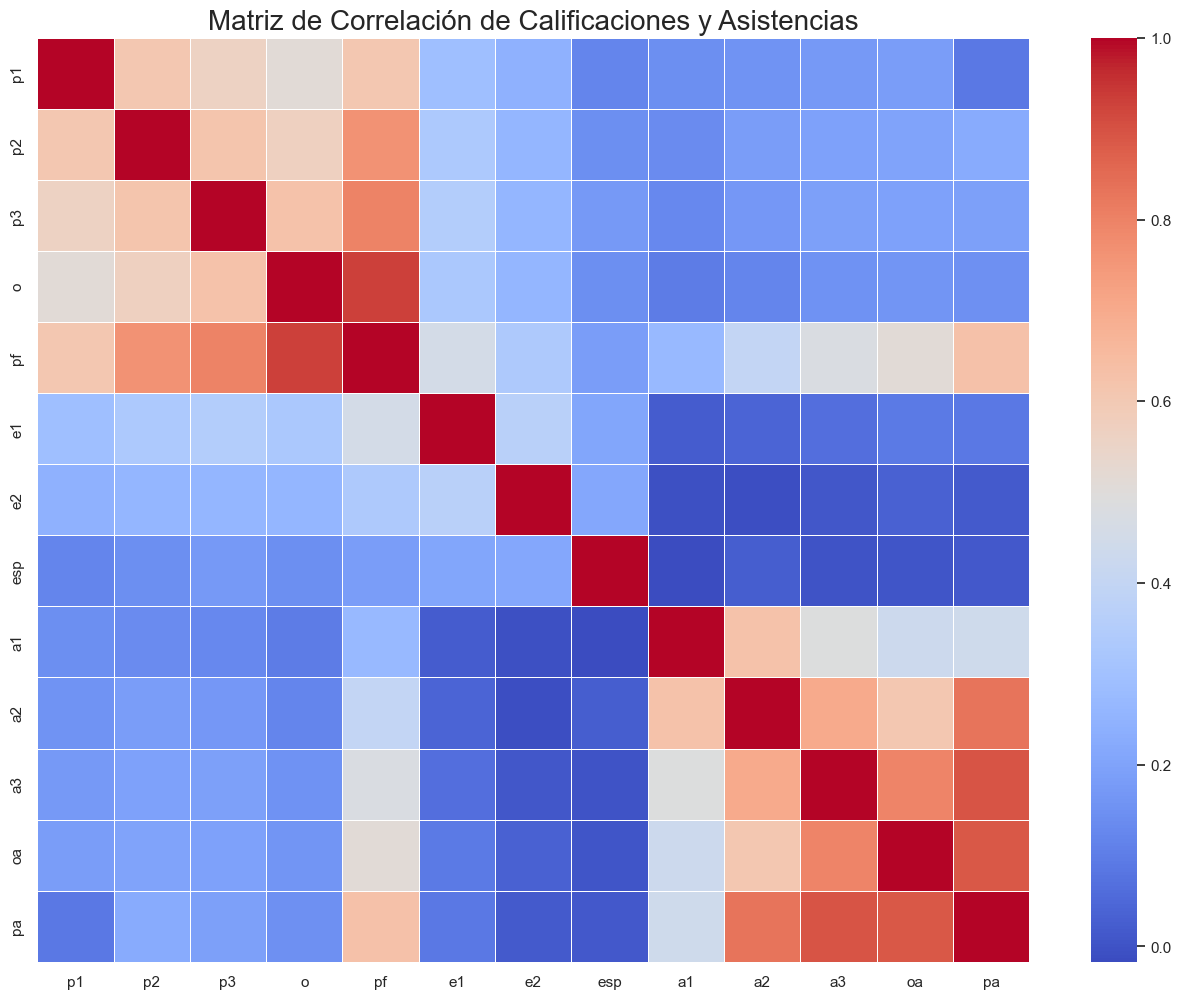

In [18]:
visualizar_matriz_correlacion(df_final_limpio)

In [28]:
def etiquetar_resultado_final(df):
    """
    Etiqueta a los alumnos basándose en si llegaron o no al décimo semestre.

    Args:
        df (pd.DataFrame): El DataFrame completo de datos de estudiantes.

    Returns:
        pd.DataFrame: El DataFrame con la nueva columna 'resultado_final'.
    """
    print("--- Etiquetando alumnos por resultado final (Término / Deserción) ---")

    # 1. Encontrar los hashes únicos de todos los alumnos que cursaron el 10mo semestre
    # Se crea un 'set' para una búsqueda muy rápida y eficiente.
    hashes_termino = set(df[df['semestre'] == 10]['alumno_carrera_hash'].unique())
    
    print(f"Se encontraron {len(hashes_termino)} alumnos que llegaron a 10mo semestre.")

    # 2. Crear la nueva columna 'resultado_final'.
    # Se usa el método .isin() que es ideal para verificar si cada hash
    # está en el conjunto de los que terminaron.
    # El resultado booleano (True/False) se convierte a entero (1/0).
    df['resultado_final'] = df['alumno_carrera_hash'].isin(hashes_termino).astype(int)

    print("Columna 'resultado_final' creada exitosamente.")
    print("1 = Término, 0 = Desertó")
    
    return df

In [29]:
df_etiquetado = etiquetar_resultado_final(df_final_limpio)

--- Etiquetando alumnos por resultado final (Término / Deserción) ---
Se encontraron 1944 alumnos que llegaron a 10mo semestre.
Columna 'resultado_final' creada exitosamente.
1 = Término, 0 = Desertó


In [30]:
print("\n--- Vista Previa del DataFrame Final (primeras 5 filas) ---")
print(df_etiquetado.head())


--- Vista Previa del DataFrame Final (primeras 5 filas) ---
   id_carrera  id_grupo  id_materia  semestre  periodo  p1  p2  p3   o   pf  \
0           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
1           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
2           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
3           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   
4           2      2975       13710         2       61 NaN NaN NaN NaN  0.0   

   ...  a3  oa    pa                                alumno_carrera_hash  \
0  ... NaN NaN  25.0  a0bb973b0416d3f4ceb601a627c9c9d99d46f306ccd699...   
1  ... NaN NaN  25.0  578d25e52a24ac996077afc11adb90698d500737270aac...   
2  ... NaN NaN  22.0  9b55af95c90111bbbd378f36809598c140d83ab73123c2...   
3  ... NaN NaN  23.0  39fbe56b18793fb13a89906b591f22edb848829b162afa...   
4  ... NaN NaN  25.0  f9e67e37da9e73eed6447e3fb490a95ea80b1ef401301d...   

   nombre_per

In [ ]:
def analisis_univariable_por_carrera(df, columna='pf'):
    """
    Realiza un análisis univariable creando un histograma de las calificaciones
    finales (pf) para cada carrera.
    """
    print("--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---")
    
    if 'id_carrera' not in df.columns or 'pf' not in df.columns:
        print("ERROR: El DataFrame debe contener las columnas 'id_carrera' y 'pf'.")
        return
        
    # Usamos FacetGrid para crear una matriz de gráficos, uno por cada carrera.
    # col_wrap=4 indica que queremos un máximo de 4 gráficos por fila.
    g = sns.FacetGrid(df, col="id_carrera", col_wrap=4, height=4, sharex=True, sharey=False)
    
    # Mapeamos un histograma a cada subplot de la matriz.
    g.map(sns.histplot, columna, kde=True, bins=20)
    
    g.fig.suptitle('Distribución de Calificaciones por Carrera: ' + columna, y=1.02, fontsize=20)
    g.set_axis_labels("Promedio (" + columna + ')', "Frecuencia")
    g.set_titles("Carrera: {col_name}")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [ ]:
def analisis_bivariable_por_carrera(df, columna1 = 'pf', columna2 = 'pa'):
    """
    Realiza un análisis bivariable creando un gráfico de dispersión
    entre asistencia (pa) y calificación (pf) para cada carrera.
    """
    print("\n--- 2. Iniciando Análisis Bivariable por Carrera (Asistencia vs. Calificación) ---")

    if 'id_carrera' not in df.columns or 'pf' not in df.columns or 'pa' not in df.columns:
        print("ERROR: El DataFrame debe contener 'id_carrera', 'pf' y 'pa'.")
        return

    # Creamos otra FacetGrid para los gráficos de dispersión.
    g = sns.FacetGrid(df, col="id_carrera", col_wrap=4, height=4, sharex=True, sharey=True)
    
    # Mapeamos un gráfico de dispersión a cada subplot.
    g.map(sns.scatterplot, columna2, columna1, alpha=0.5)
    
    g.map(sns.regplot, columna2, columna1, scatter=False, color='red')

    g.fig.suptitle('Relación Asistencia vs. Calificación por Carrera', y=1.02, fontsize=20)
    g.set_axis_labels("(" + columna2 + ")", "(" + columna1 + ")")
    g.set_titles("Carrera: {col_name}")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\1809746170.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para que el título principal no se superponga


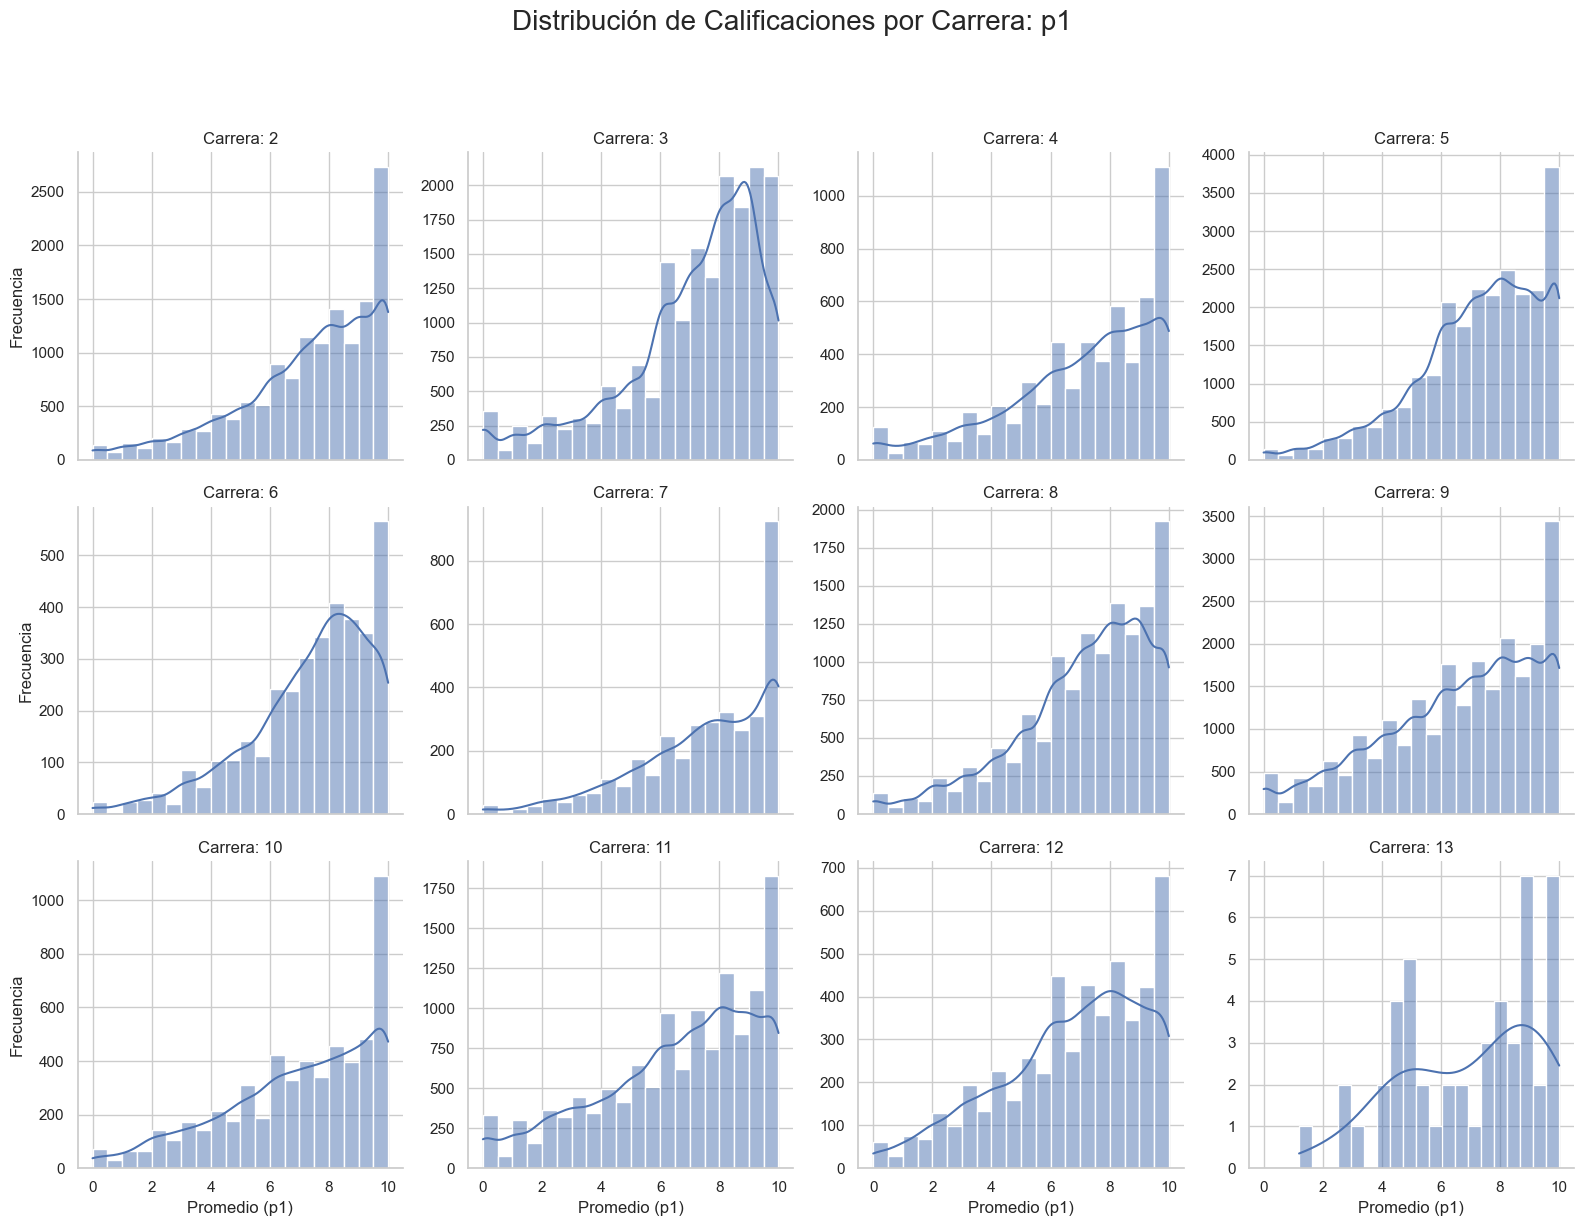

In [33]:
analisis_univariable_por_carrera(df_etiquetado, columna='p1')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\1809746170.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para que el título principal no se superponga


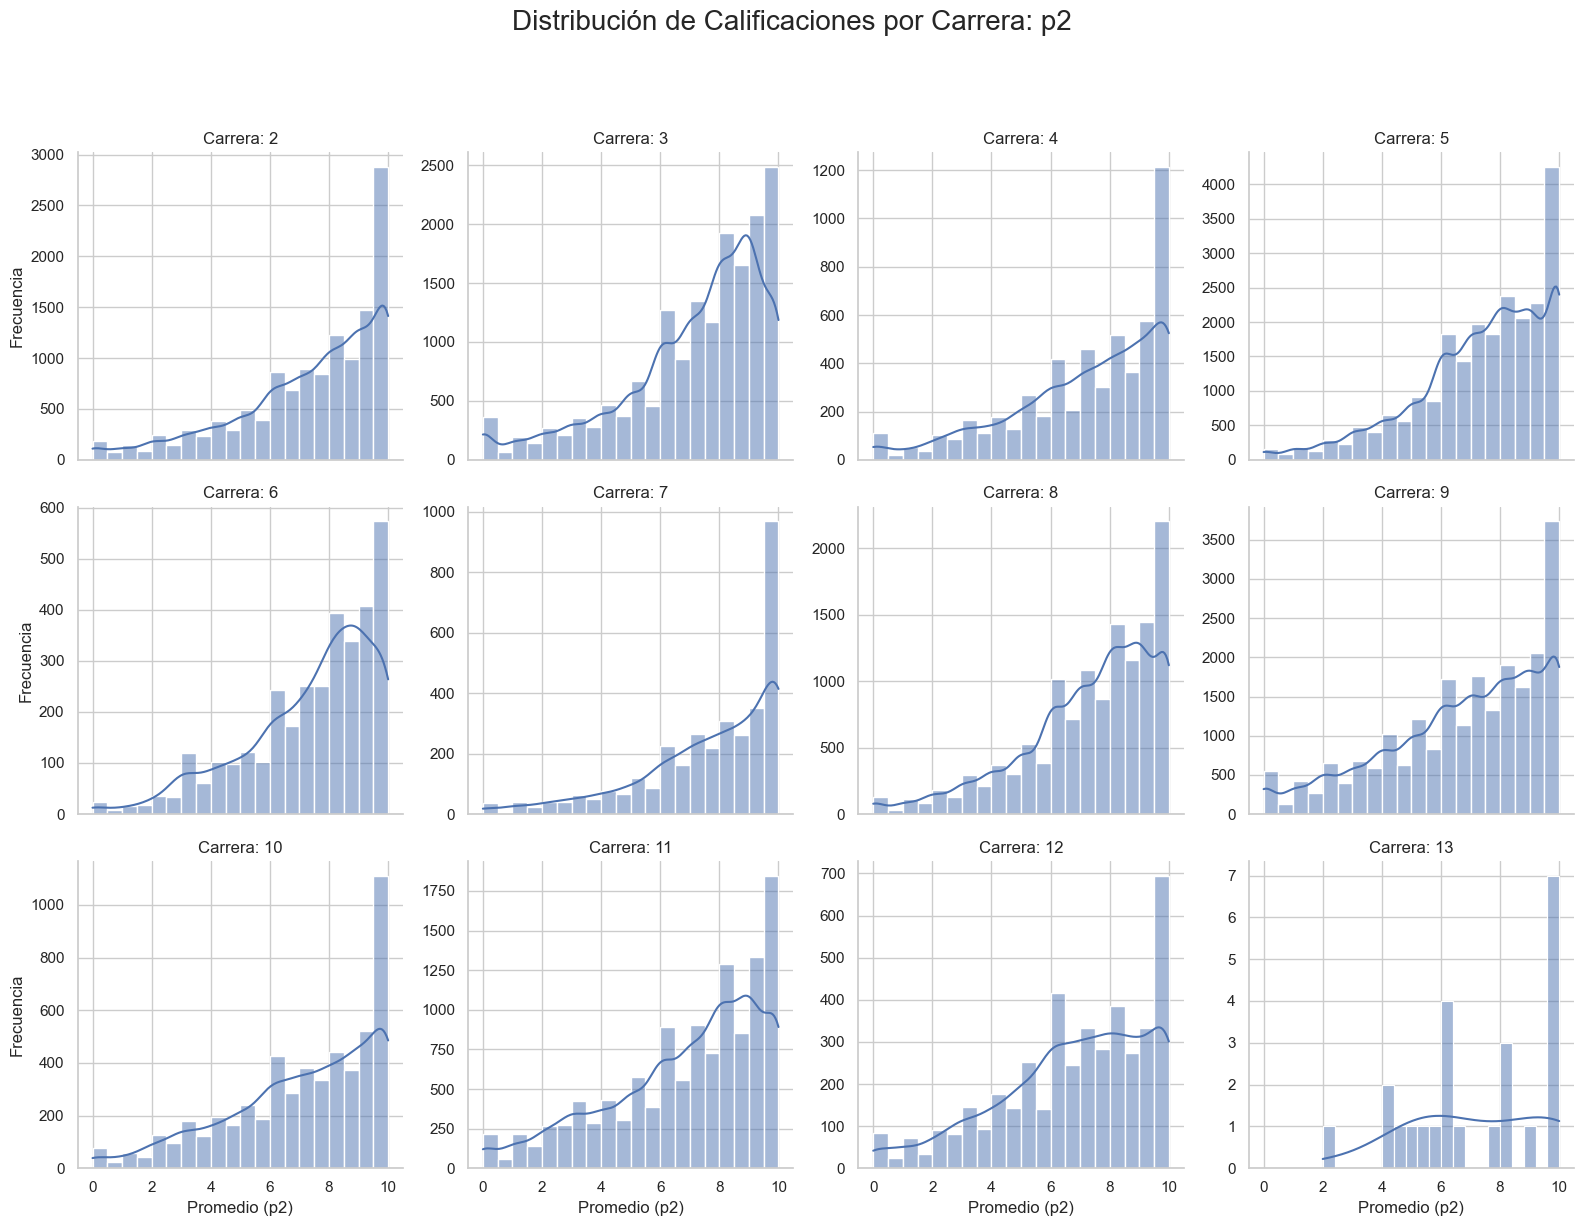

In [34]:
analisis_univariable_por_carrera(df_etiquetado, columna='p2')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\1809746170.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para que el título principal no se superponga


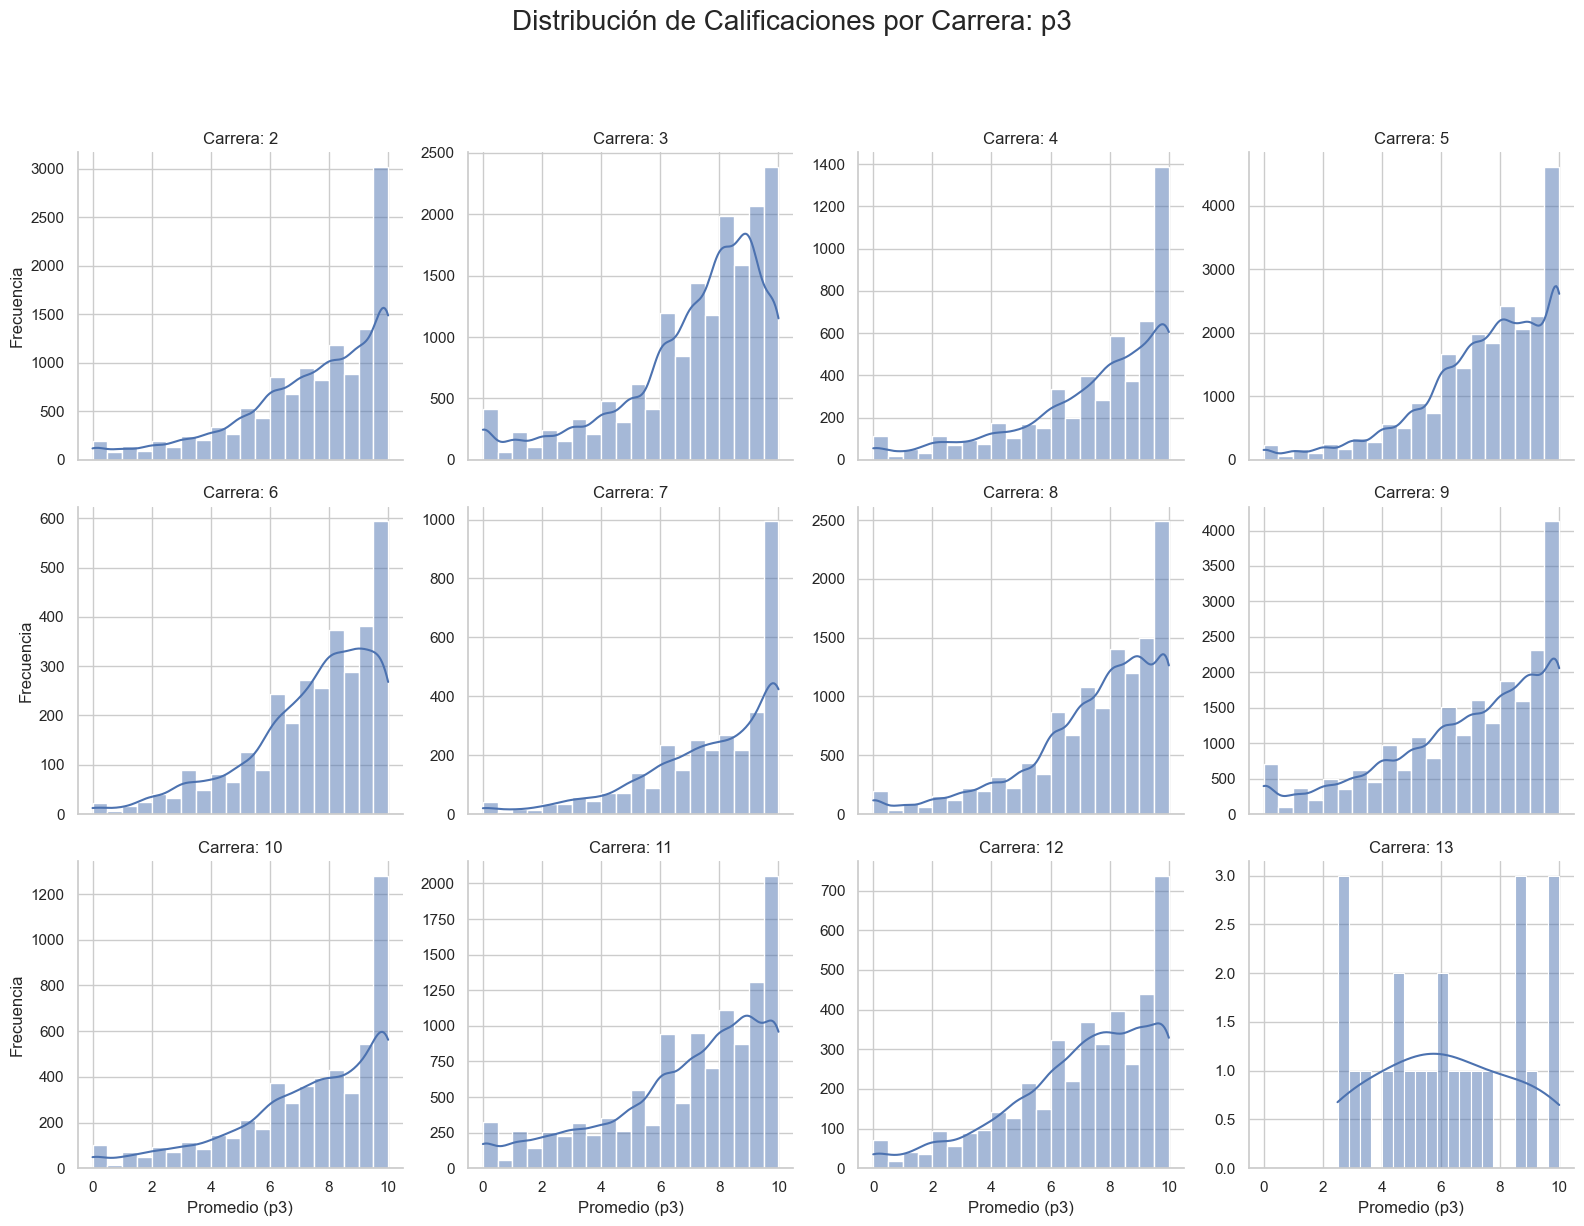

In [35]:
analisis_univariable_por_carrera(df_etiquetado, columna='p3')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\1809746170.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para que el título principal no se superponga


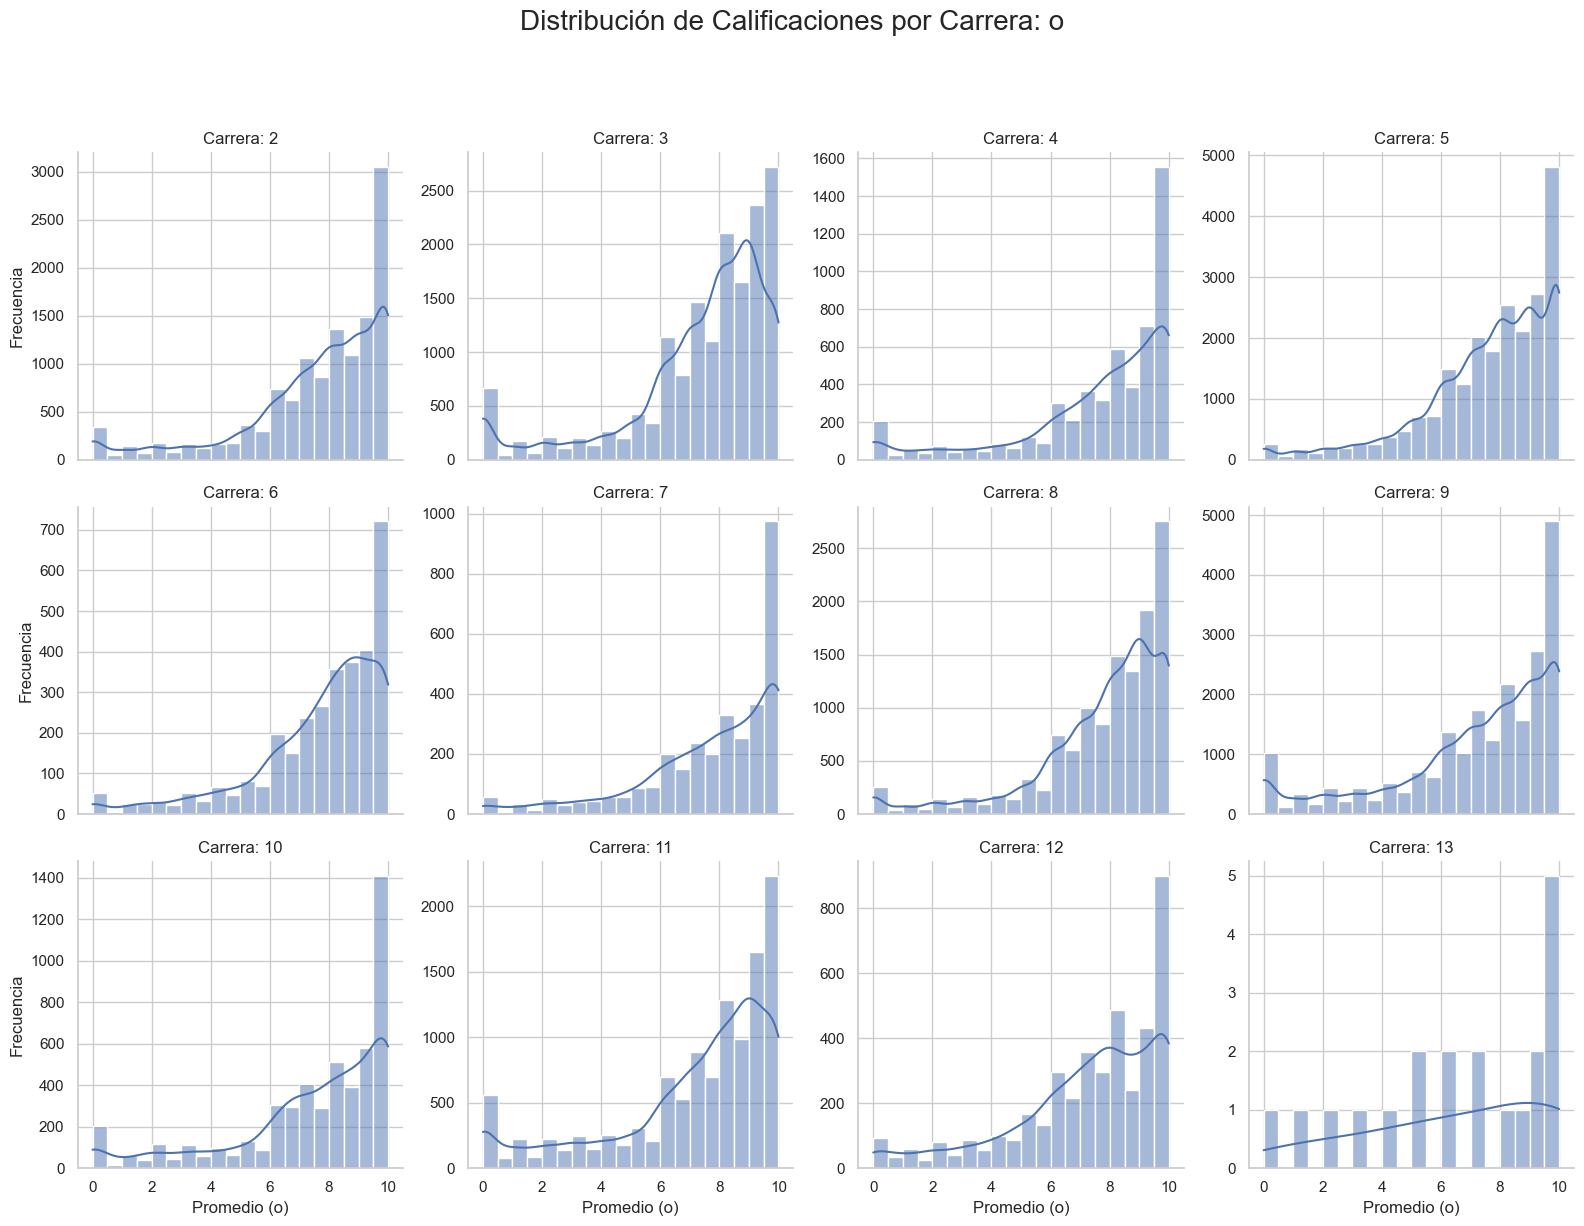

In [36]:
analisis_univariable_por_carrera(df_etiquetado, columna='o')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\1809746170.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para que el título principal no se superponga


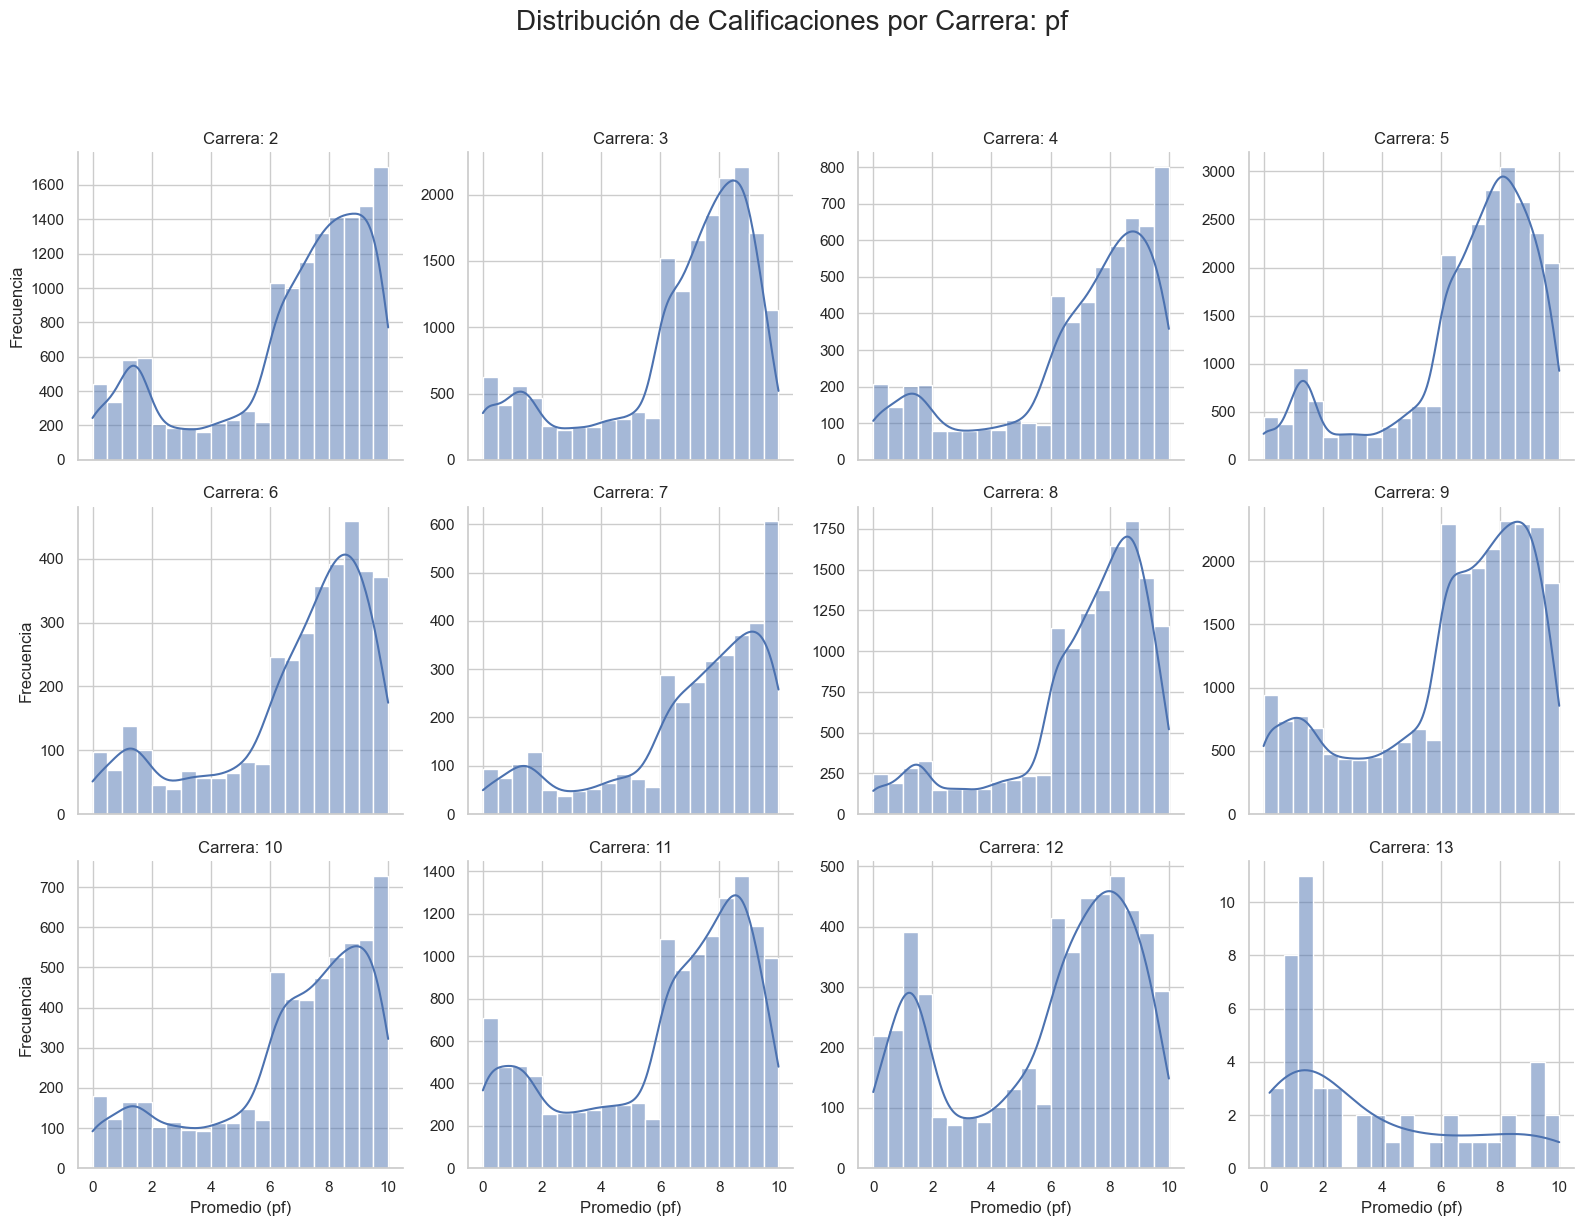

In [37]:
analisis_univariable_por_carrera(df_etiquetado, columna='pf')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\1809746170.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para que el título principal no se superponga


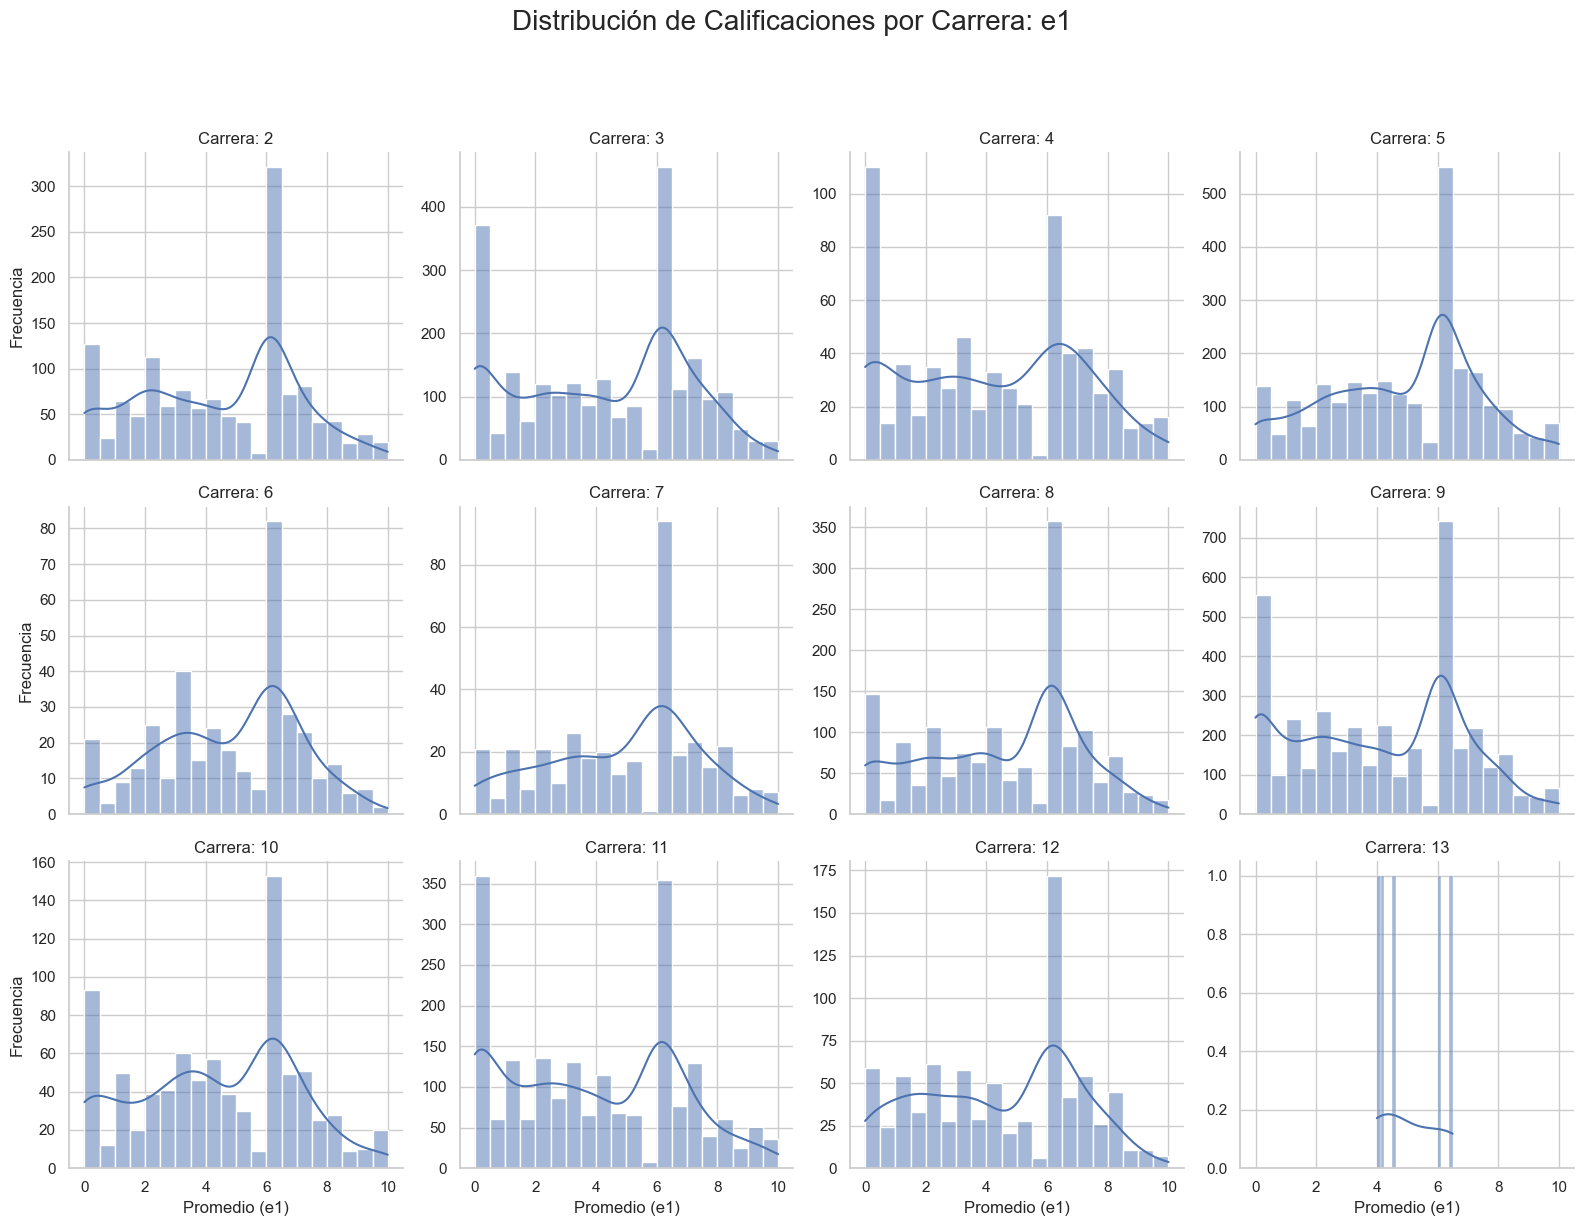

In [38]:
analisis_univariable_por_carrera(df_etiquetado, columna='e1')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\1809746170.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para que el título principal no se superponga


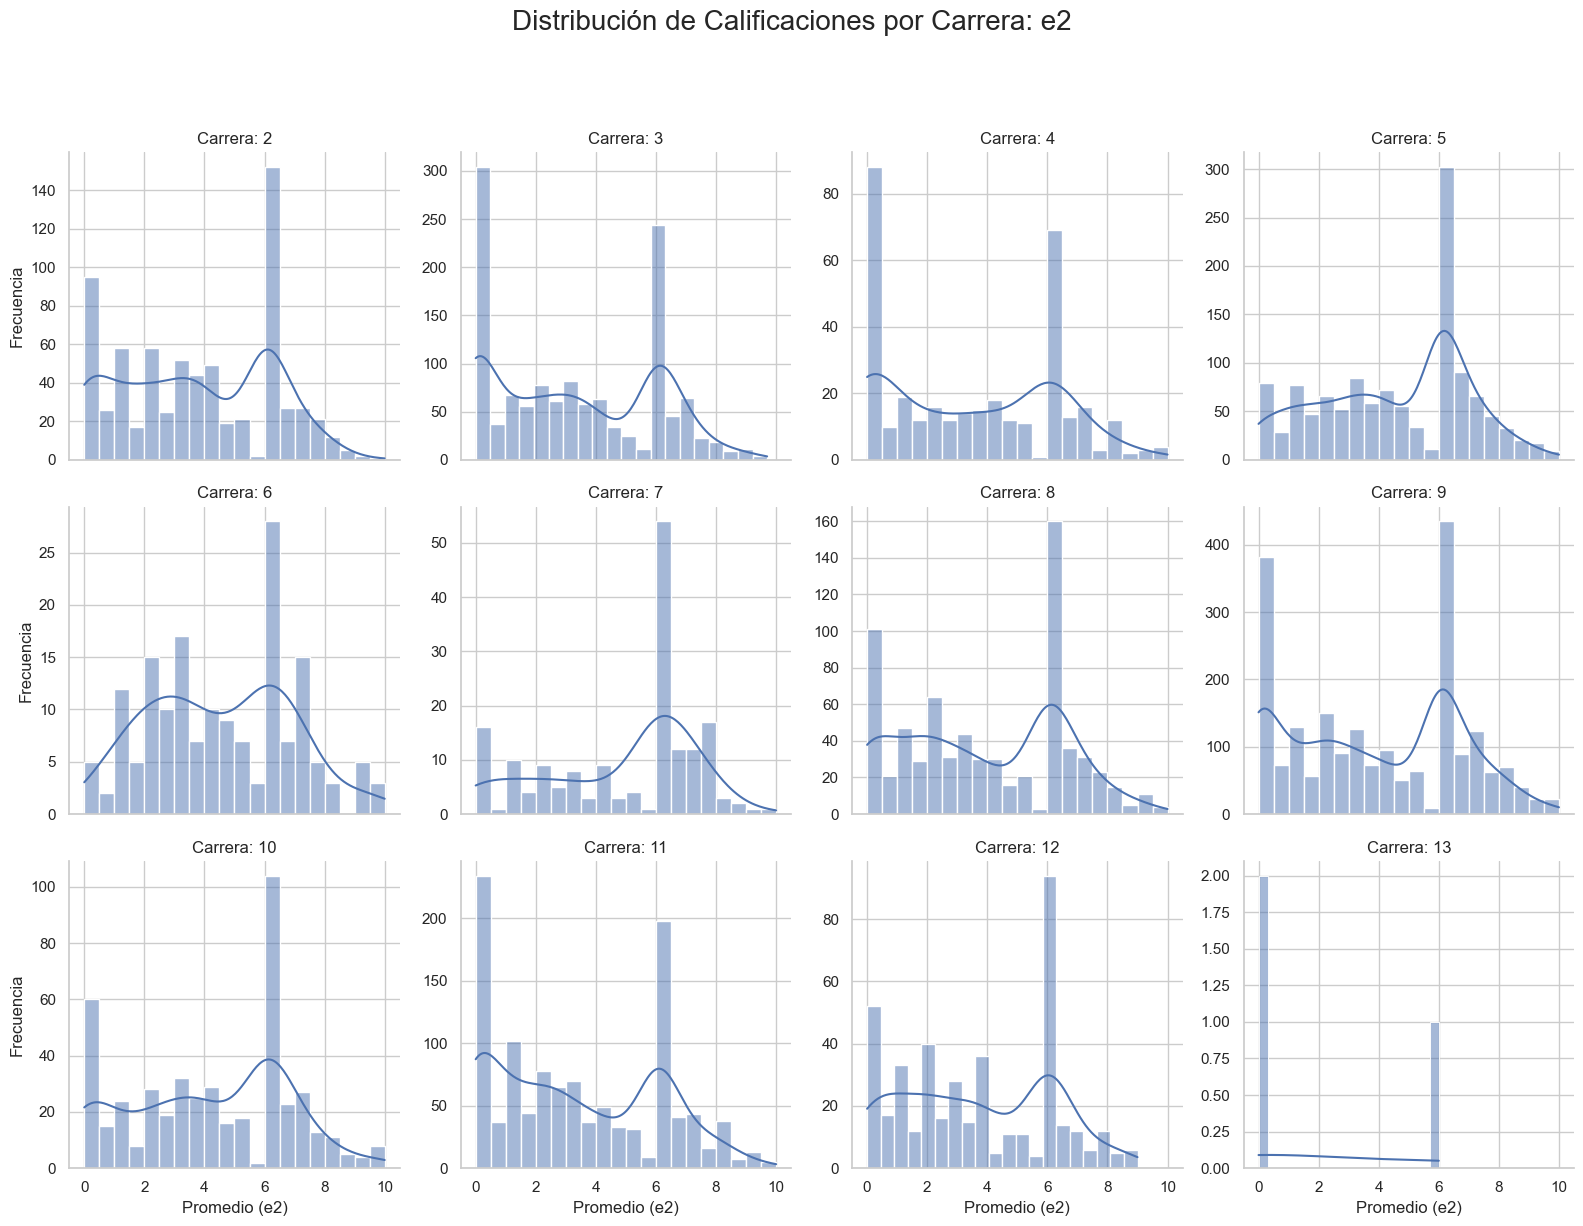

In [39]:
analisis_univariable_por_carrera(df_etiquetado, columna='e2')

--- 1. Iniciando Análisis Univariable por Carrera (Histogramas de 'pf') ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\1809746170.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97]) # Ajustar para que el título principal no se superponga


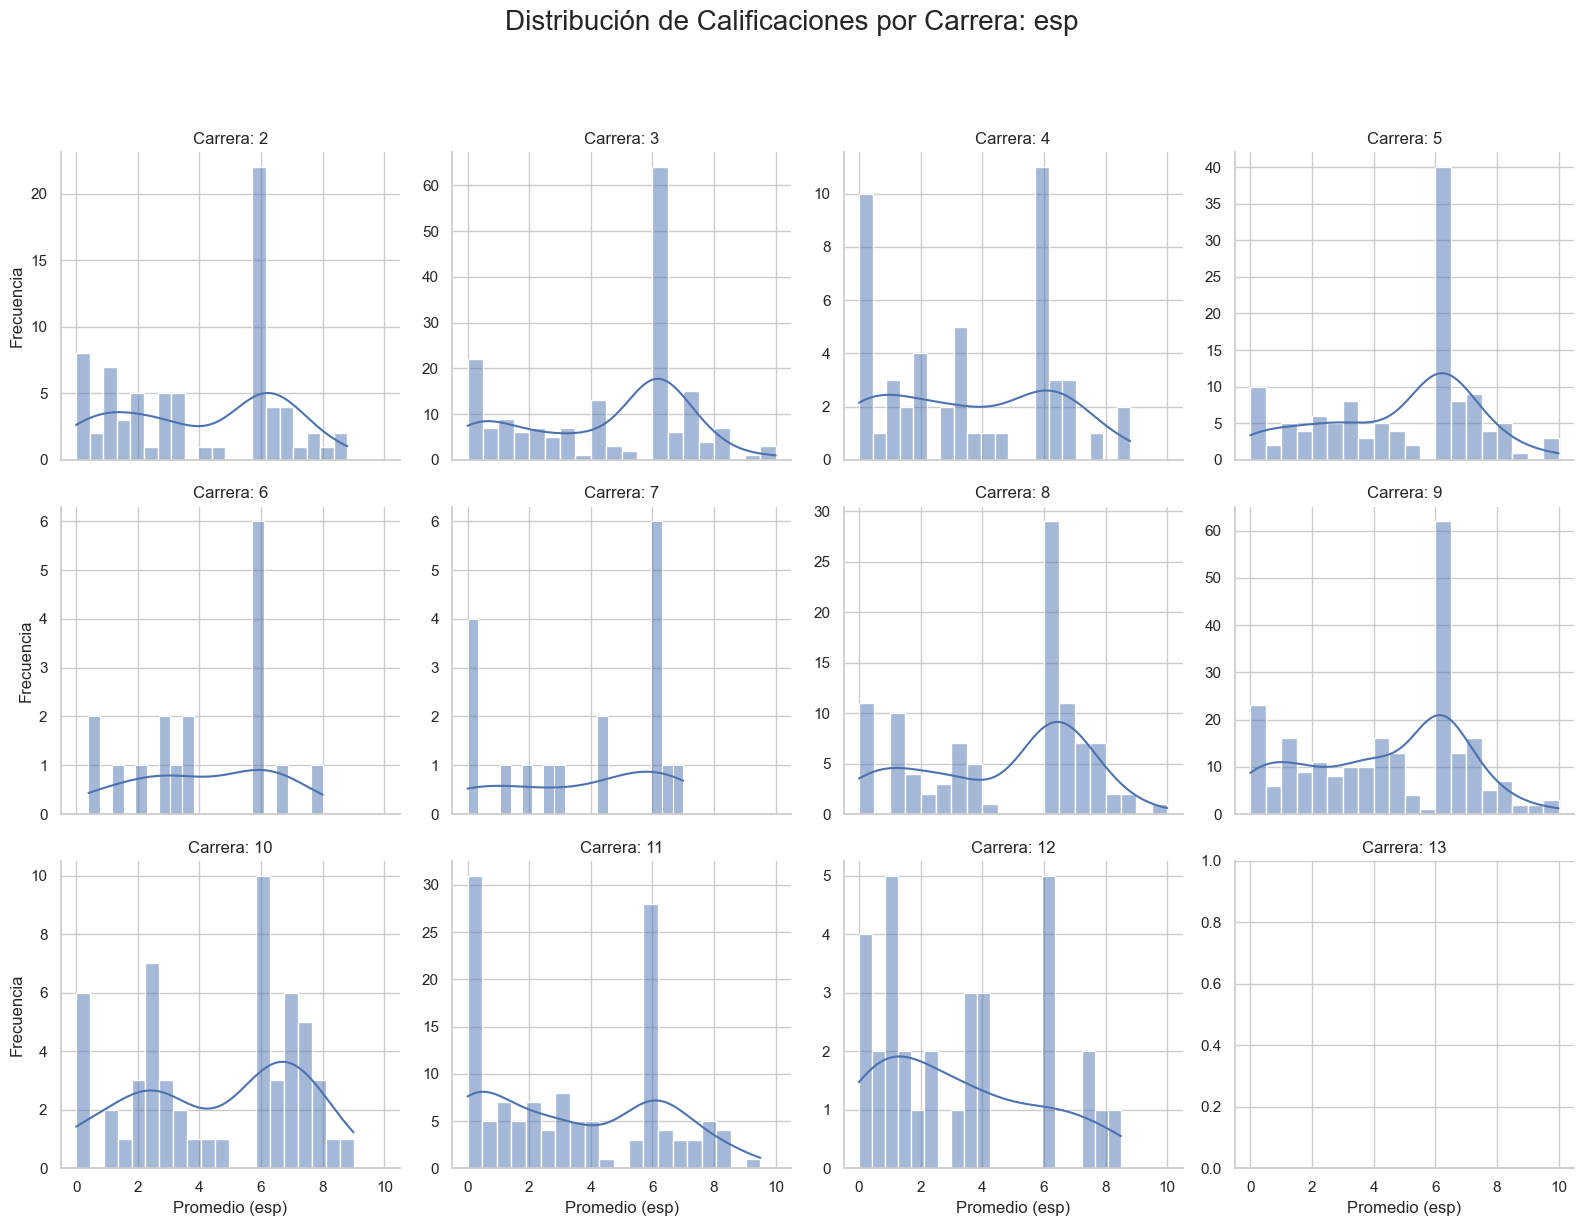

In [40]:
analisis_univariable_por_carrera(df_etiquetado, columna='esp')


--- 2. Iniciando Análisis Bivariable por Carrera (Asistencia vs. Calificación) ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\2948075345.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


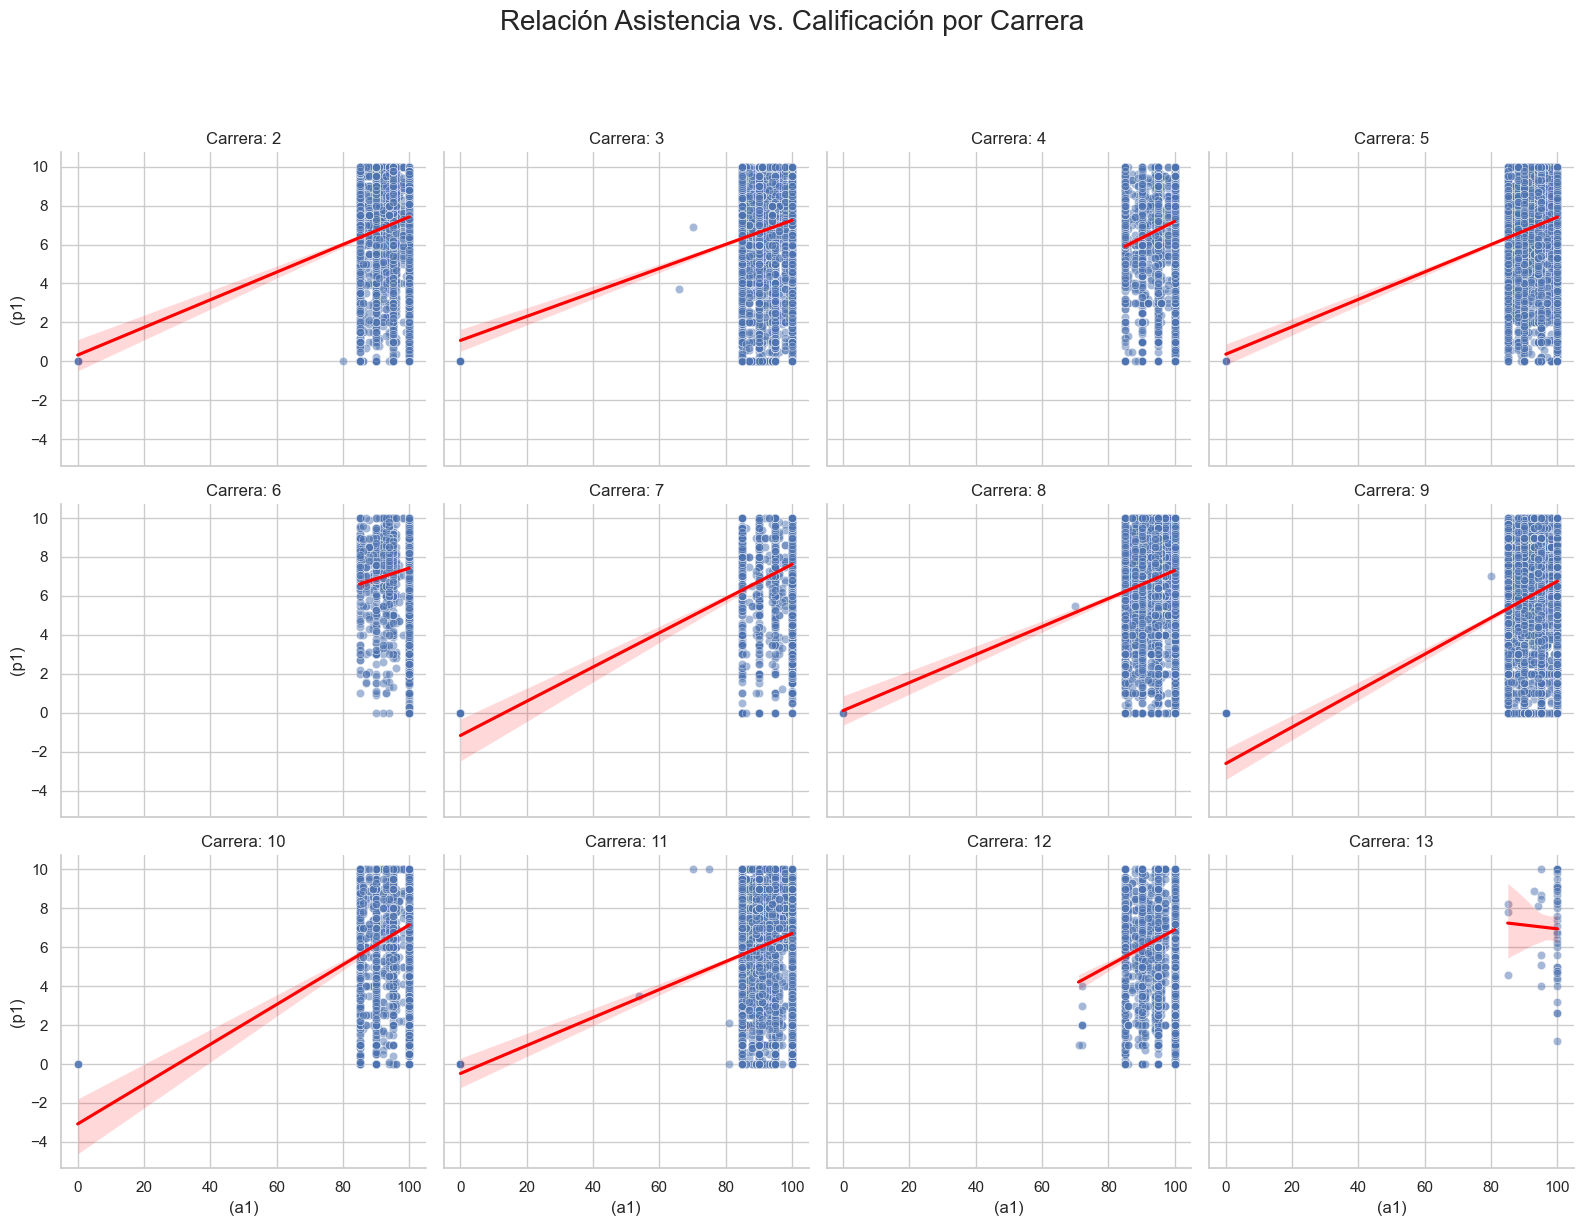

In [41]:
analisis_bivariable_por_carrera(df_etiquetado, columna1='p1', columna2='a1')


--- 2. Iniciando Análisis Bivariable por Carrera (Asistencia vs. Calificación) ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\2948075345.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


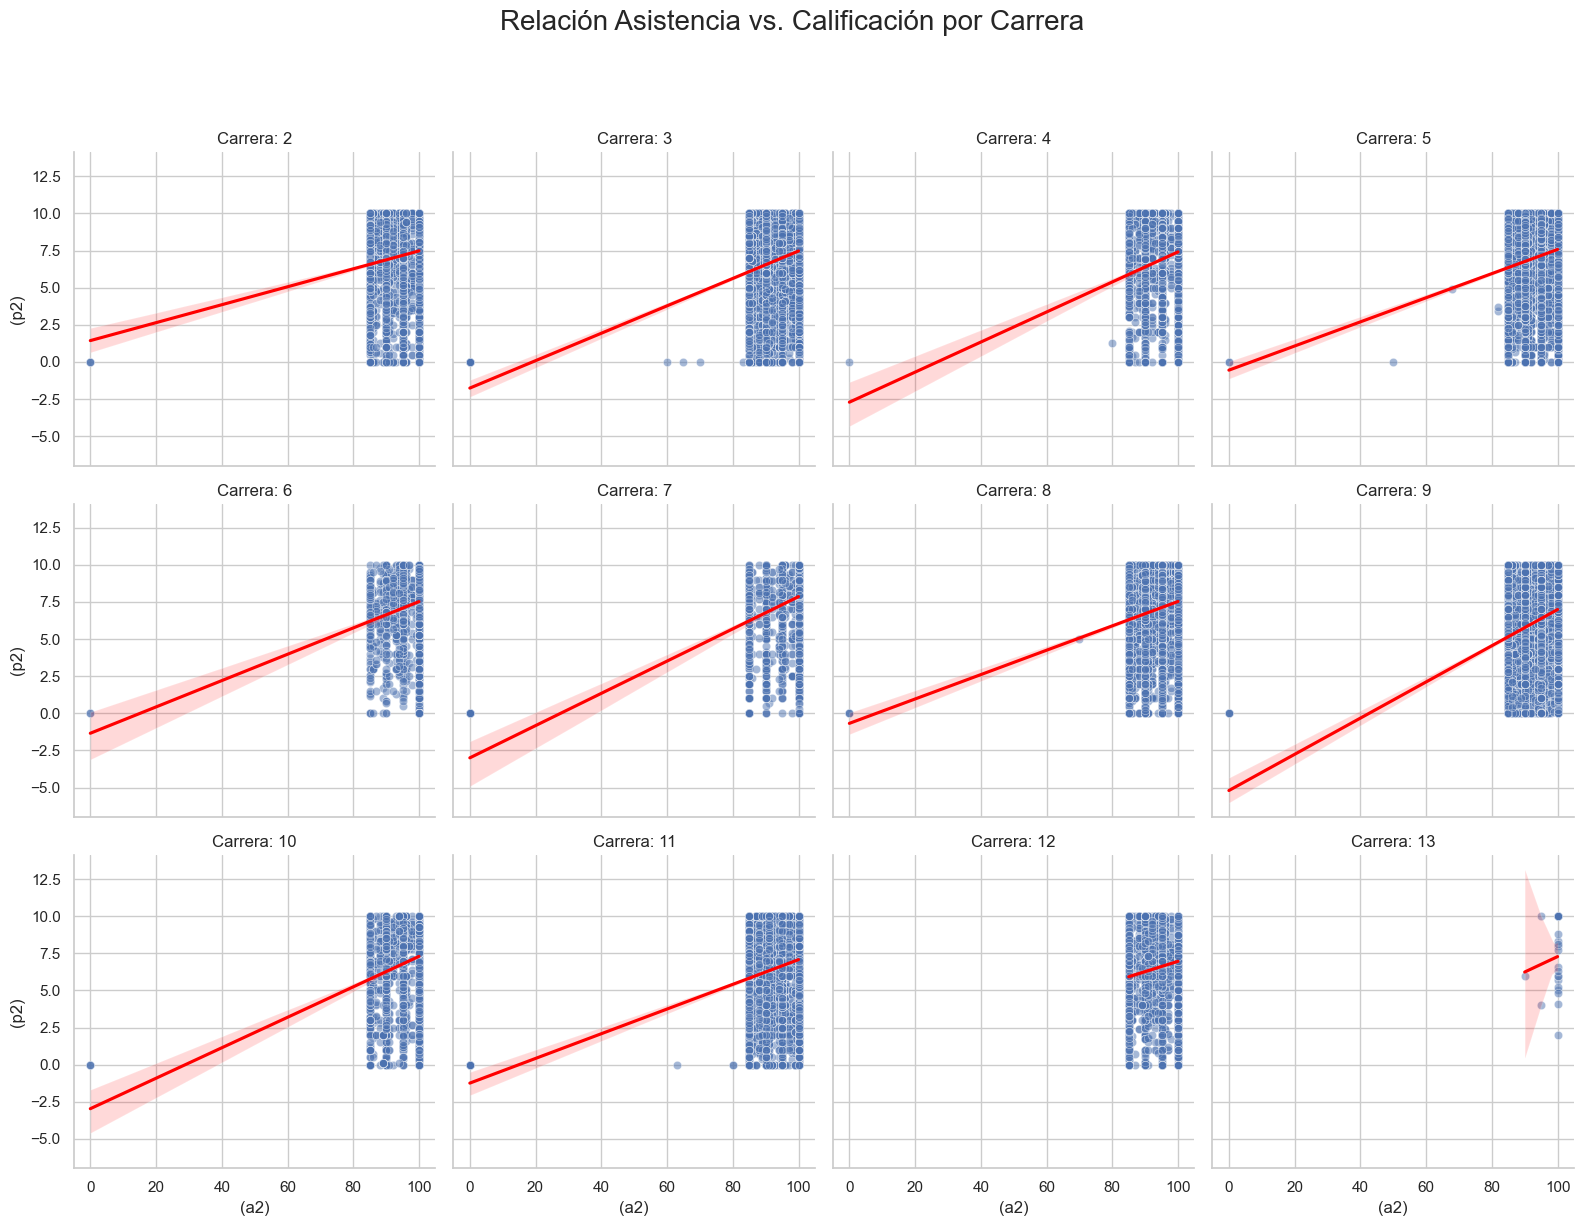

In [42]:
analisis_bivariable_por_carrera(df_etiquetado, columna1='p2', columna2='a2')


--- 2. Iniciando Análisis Bivariable por Carrera (Asistencia vs. Calificación) ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\2948075345.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


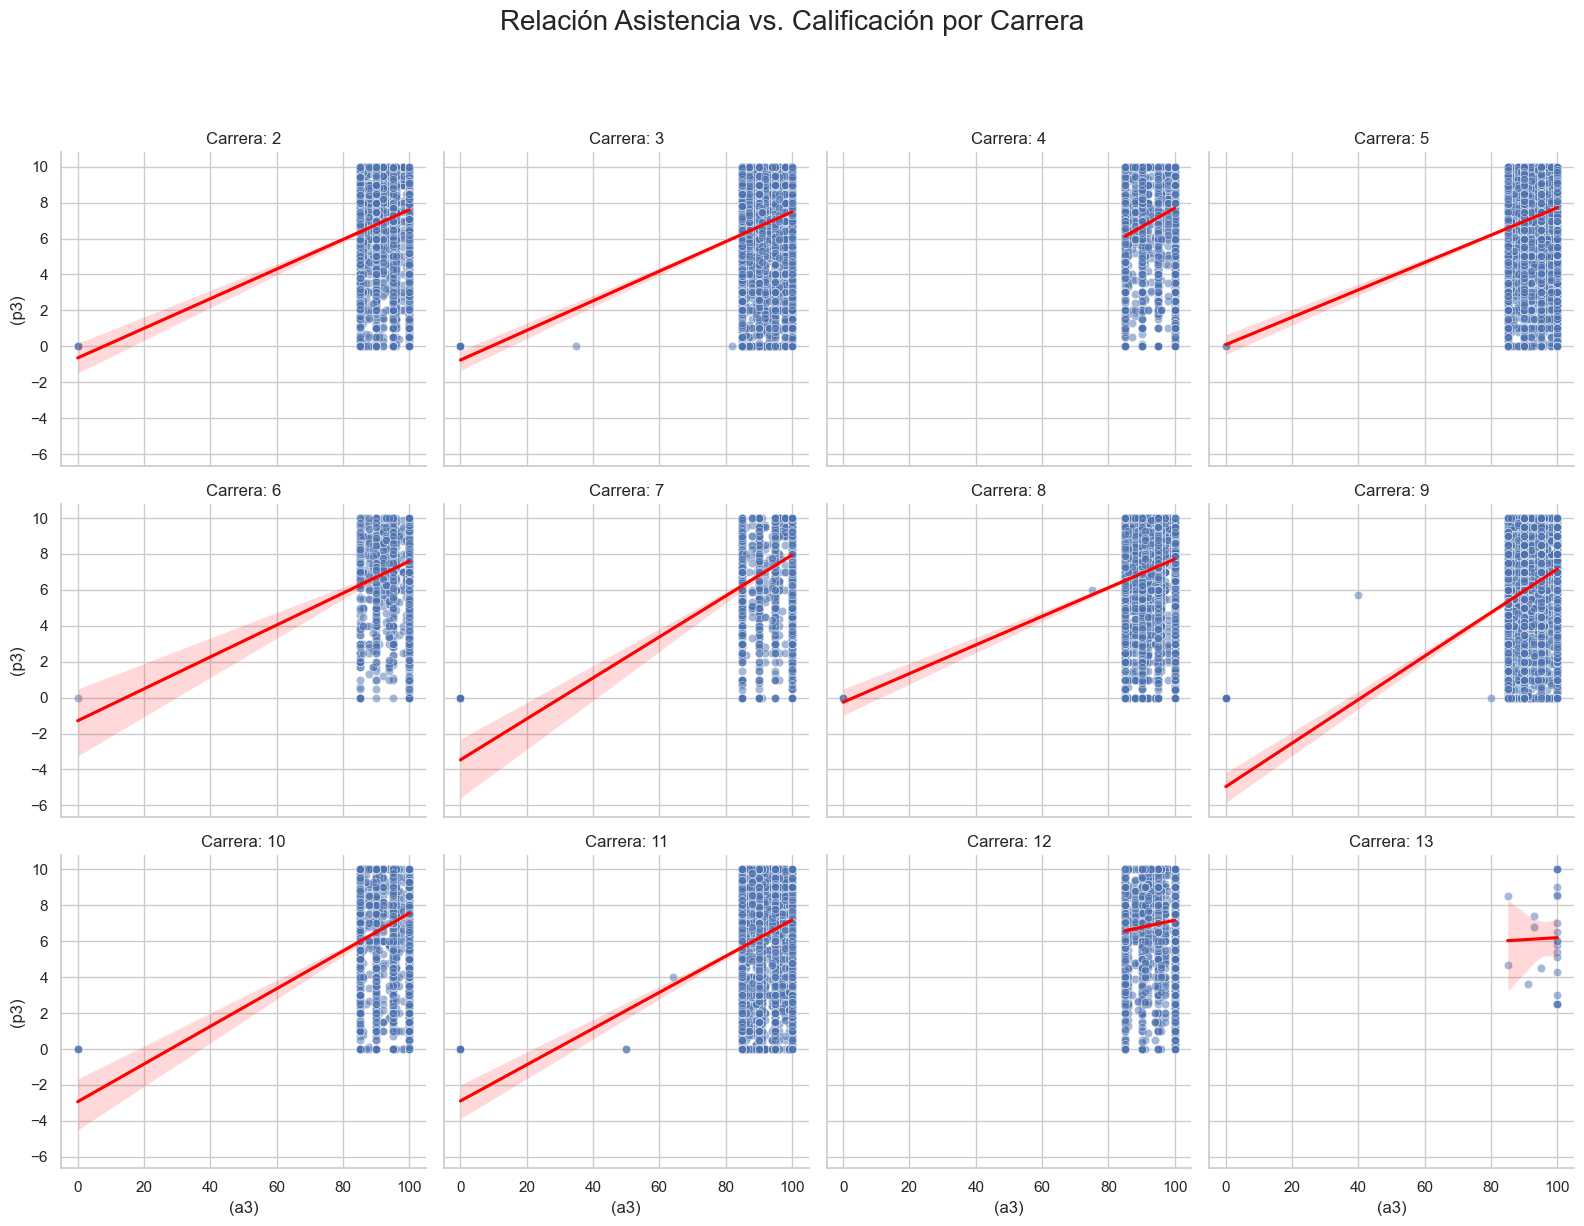

In [43]:
analisis_bivariable_por_carrera(df_etiquetado, columna1='p3', columna2='a3')


--- 2. Iniciando Análisis Bivariable por Carrera (Asistencia vs. Calificación) ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\2948075345.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


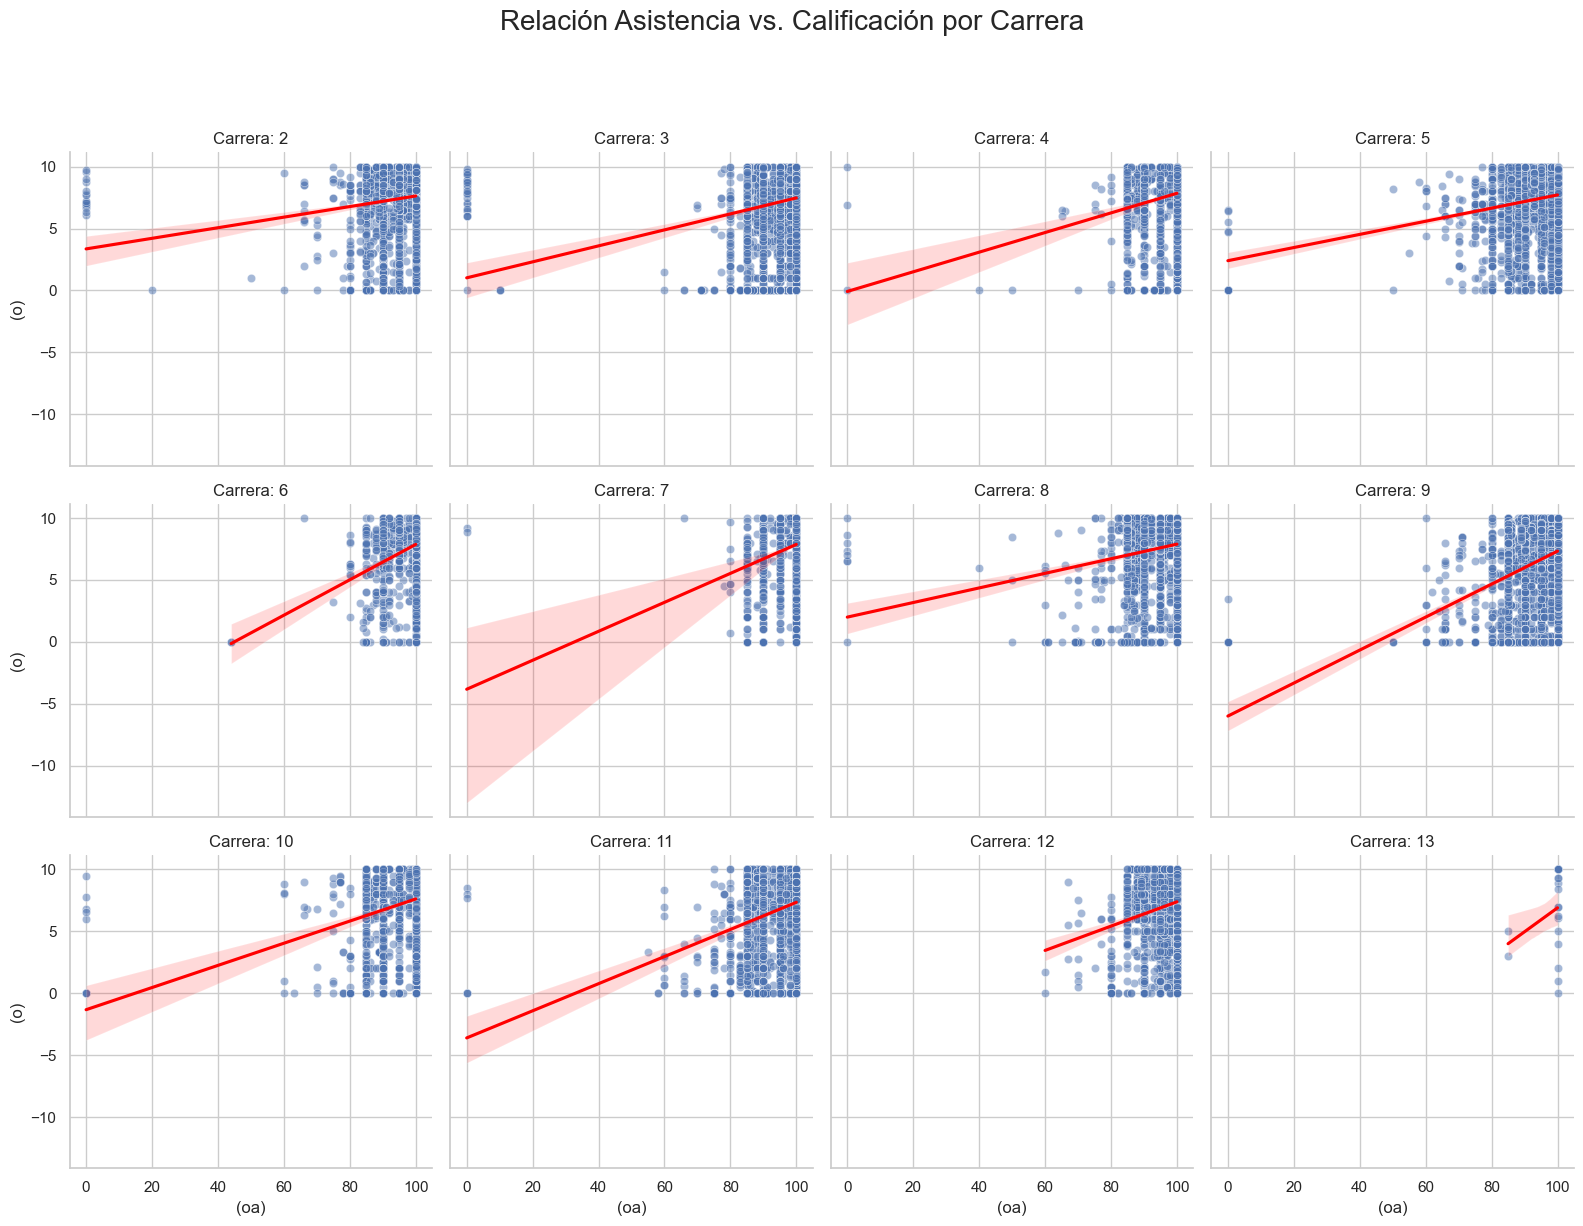

In [44]:
analisis_bivariable_por_carrera(df_etiquetado, columna1='o', columna2='oa')


--- 2. Iniciando Análisis Bivariable por Carrera (Asistencia vs. Calificación) ---


d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
d:\Nueva carpeta\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\LAG PC\AppData\Local\Temp\ipykernel_25452\2948075345.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.97])


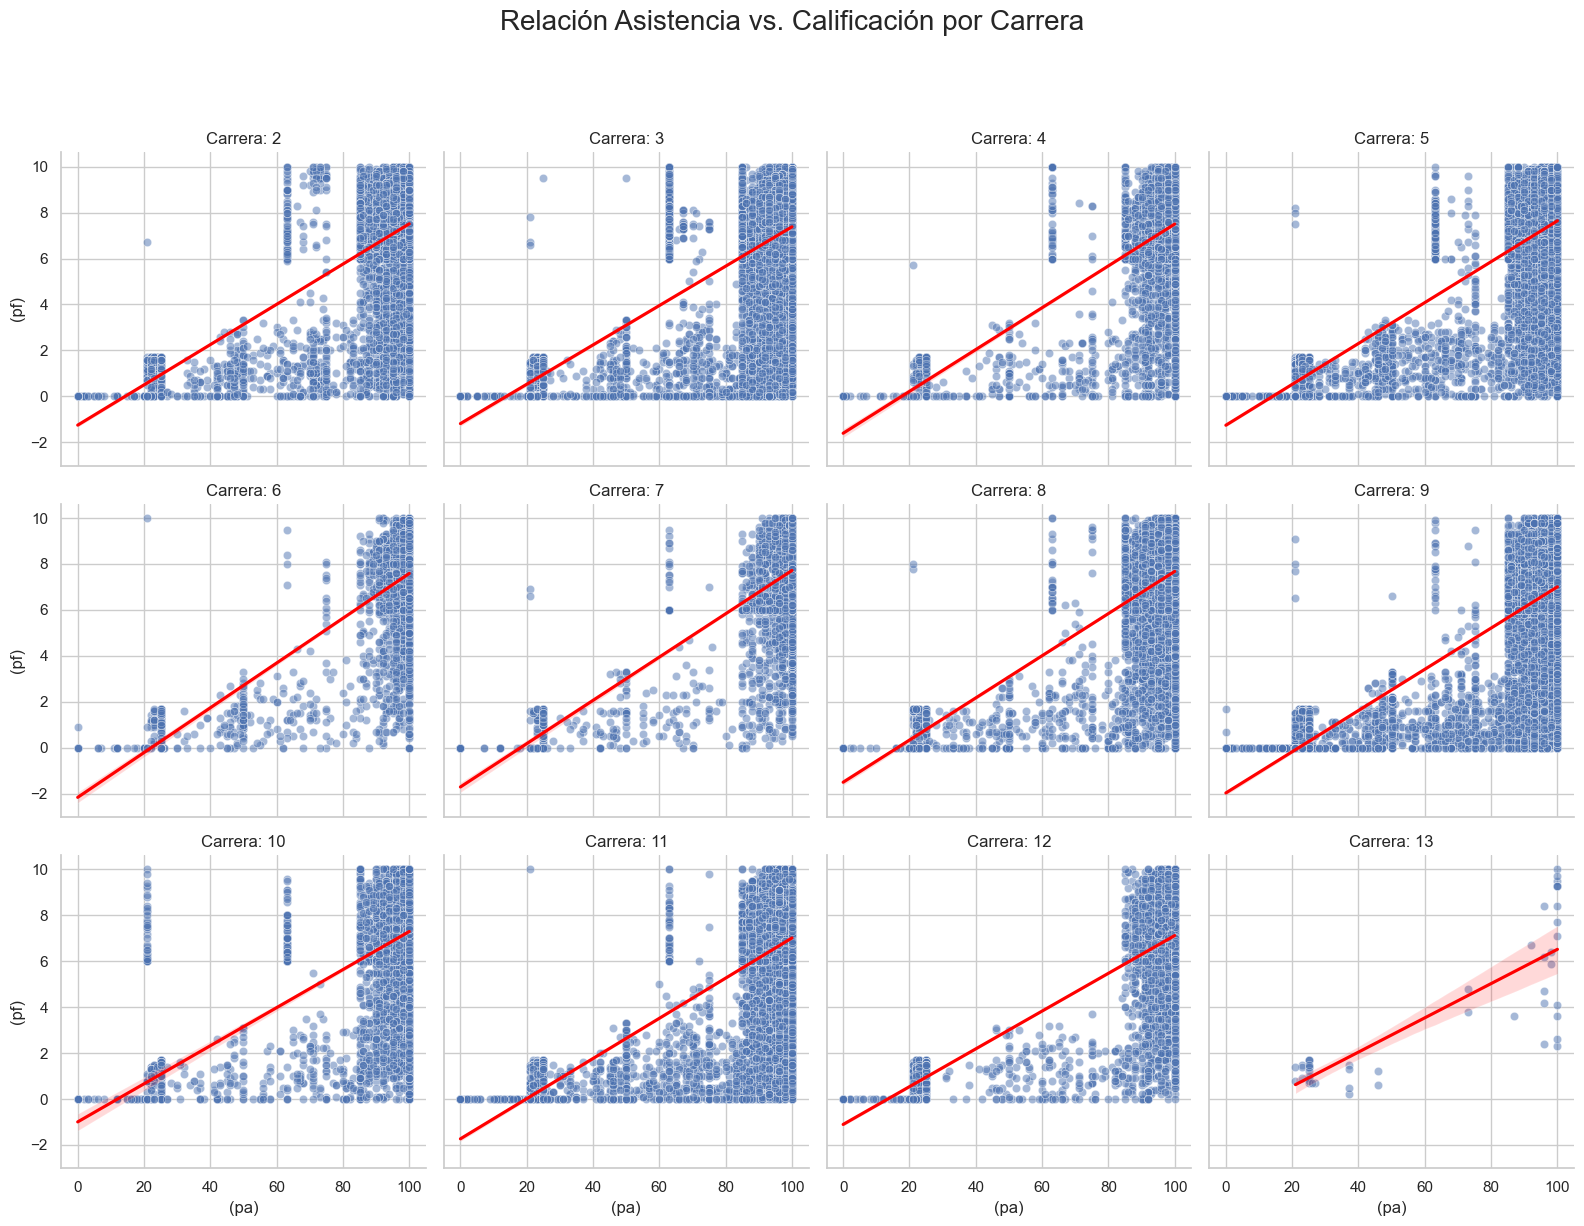

In [45]:
analisis_bivariable_por_carrera(df_etiquetado, columna1='pf', columna2='pa')